https://medium.com/@connectwithghosh/simple-autoencoder-example-using-tensorflow-in-python-on-the-fashion-mnist-dataset-eee63b8ed9f1
https://gertjanvandenburg.com/blog/autoencoder/
http://machinelearninguru.com/deep_learning/tensorflow/neural_networks/autoencoder/autoencoder.html#list
https://towardsdatascience.com/deep-autoencoders-using-tensorflow-c68f075fd1a3
https://towardsdatascience.com/autoencoders-introduction-and-implementation-3f40483b0a85

## Imports

In [12]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import ROOT
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import os
import sys
import hickle
# import seaborn as sns

In [13]:
sys.path.insert(0, '../../allpixAnalysis/')
sys.path.insert(0, '../../getConversionFactors/')
import plotChargeHisto as pch
import getConversionFactors_ROOT as gcfr
sys.path.insert(0, '../classifier/')
import generate_data as gd

## Constants and Flags

In [14]:
# Use 16 bins like in DosiMode
TRUE_BINNING = False
binEdges = {'vac': [12, 18, 21, 24.5, 33.5, 43, 53.5, 66.5, 81.5, 97, 113, 131.5, 151.5, 173, 200.5, 236, 430],
    'sn': [32, 37, 47, 57.5, 68.5, 80, 91.5, 104, 117, 131, 145, 163.5, 183.5, 207.5, 234.5, 269.5, 430],
    'al': [12, 17, 31, 40, 45.5, 50.5, 60.5, 68, 91, 102.5, 133, 148, 163, 196, 220, 257, 430]}

# Use convolutional ae
USE_CONV = True
ROOT_DATA_HCK = True
root_data_hck = 'root_data.hck'

# Train on deconvolution data
DECONV = True
DECONV_DATA_HCK = True
DECONV_SQUARE = False
DECONV_N = True

# Deconvolve spectrum
deconv_data_single_hck = 'deconv_data_single'
deconv_data_square_hck = 'deconv_data_square'
deconv_data_N_hck = 'deconv_data_N'

if TRUE_BINNING:
    OUTPUT_LENGTH = 16
    deconv_data_single_hck += '_bin'
    deconv_data_square_hck += '_bin'
else:
    OUTPUT_LENGTH = 121
    
deconv_data_N_hck += '.hck'
deconv_data_single_hck += '.hck'
deconv_data_square_hck += '.hck'
    
if DECONV_SQUARE:
    deconv_data_hck = deconv_data_square_hck
elif DECONV_N:
    deconv_data_hck = deconv_data_N_hck
else:
    deconv_data_hck = deconv_data_single_hck
    
BINS_EVAL = 43

## Load Deconvolution Data

In [ ]:
deconv_data_hck = '../classifier/label_deconv_data_importance_randN.hck' # 'deconv_data.hck'

d = hickle.load(deconv_data_hck)
bins = d['bins']
N_hists = d['N']
deconv_data, deconv_data_true = d['deconv_data'], d['deconv_data_true']
deconv_data_test, deconv_data_true_test = d['deconv_data_test'], d['deconv_data_true_test']

# Filter NaNs
keep = ~np.isnan(deconv_data['vac']).any(axis=1)
deconv_data = {t: np.asarray(deconv_data[t])[keep] for t in deconv_data.keys()}
deconv_data_true = np.asarray(deconv_data_true)[keep]

keep = ~np.isnan(deconv_data_test['vac']).any(axis=1)
deconv_data_test = {t: np.asarray(deconv_data_test[t])[keep] for t in deconv_data_test.keys()}
deconv_data_true_test = np.asarray(deconv_data_true_test)[keep]

for idx in range(5):
    for t in ['vac', 'al', 'sn']:
        if TRUE_BINNING:
            bins = binEdges[t]
        plt.step(bins[:-1], deconv_data[t][idx], where='post')
    plt.step(np.arange(len(deconv_data_true[idx])), deconv_data_true[idx], where='post')
    plt.show()
    plt.close()

In [5]:
print len(deconv_data['vac'][0])
print len(deconv_data_test['vac'])
print len(deconv_data_true_test)

59
860
860


## Model Definition

In [6]:
def add_hidden_layer_summary(value):
  tf.summary.scalar('fraction_of_zero_values', tf.nn.zero_fraction(value))
  tf.summary.histogram('activation', value)

In [54]:
def encoder(inputs, hidden_units, dropout, is_training):
    net = inputs
    for num_hidden_units in hidden_units:
        net = tf.contrib.layers.fully_connected(
            net, num_outputs=num_hidden_units)
        if dropout is not None:
            net = slim.dropout(net, is_training=is_training)
        add_hidden_layer_summary(net)
    return net
  
def conv_encoder(inputs, hidden_units, dropout, scope=None):
    net = inputs
    with tf.variable_scope(scope, 'encoder', [inputs]):
        for layer_id, num_outputs in enumerate(hidden_units):
            with tf.variable_scope('block{}'.format(layer_id)):
                # net = slim.repeat(net, 2, tf.layers.conv1d, filters=num_outputs,
                #                  kernel_size=3, padding="SAME")
                # net = tf.layers.conv1d(net, filters=num_outputs, kernel_size=3, padding="SAME")
                net = tf.layers.conv2d(
                    inputs=net,
                    filters=num_outputs,
                    kernel_size=[3, 3],
                    padding="same",
                    activation=tf.nn.relu)
                # net = tf.contrib.layers.max_pool2d(net, kernel_size=2)
 
        net = tf.identity(net, name='output')
        print 'Encoder Output:', net
    return net

In [85]:
def decoder(inputs, hidden_units, dropout, is_training):
    net = inputs
    for num_hidden_units in hidden_units[:-1]:
        net = tf.contrib.layers.fully_connected(
            net, num_outputs=num_hidden_units)
        if dropout is not None:
            net = slim.dropout(net, is_training=is_training)
        add_hidden_layer_summary(net)
 
    net = tf.contrib.layers.fully_connected(net, hidden_units[-1], activation_fn=None)
    tf.summary.histogram('activation', net)
    return net
  
def conv_decoder(inputs, hidden_units, dropout, scope=None, batch_size=100, output_length=149):
    net = inputs
    with tf.variable_scope(scope, 'decoder', [inputs]):
        print 'Hidden units:', hidden_units
        for layer_id, num_outputs in enumerate(hidden_units[:-1]):
            with tf.variable_scope('block_{}'.format(layer_id),
                                   values=(net,)):
                # net = tf.contrib.nn.conv1d_transpose(net, tf.Variable(tf.random_normal([3, hidden_units[layer_id+1], num_outputs], dtype=tf.float32)), [batch_size, 1, hidden_units[layer_id+1]], 1, padding='SAME')
                net = tf.layers.conv2d_transpose(
                    inputs=net,
                    filters=hidden_units[layer_id+1],
                    kernel_size=[3, 3],
                    padding="same",
                    activation=tf.nn.relu)

        '''
        with tf.variable_scope('linear', values=(net,)):
            # net = tf.contrib.nn.conv1d_transpose(net, tf.Variable(tf.random_normal([1, output_length, hidden_units[-1]], dtype=tf.float32)), [batch_size, 1, output_length], 1, padding='SAME')
            net = tf.layers.conv2d_transpose(
                inputs=net,
                filters=1,
                kernel_size=[3, 1],
                padding="same")
        '''
           
        # net = tf.nn.relu(net) # 
        net = tf.reshape(net, [-1, 3 * 59 * hidden_units[-1]])
        net = tf.layers.dense(inputs=net, units=512, activation=tf.nn.relu)
        net = tf.layers.dense(inputs=net, units=256, activation=tf.nn.relu)
        net = tf.layers.dense(inputs=net, units=output_length, activation=None)
        net = tf.abs(net)
        print 'Decoder output:', net

    return net

In [86]:
def autoencoder(inputs, hidden_units, activation_fn, dropout, weight_decay, mode, output_length):
    is_training = (mode == tf.estimator.ModeKeys.TRAIN)
 
    weights_init = slim.initializers.variance_scaling_initializer()
    if weight_decay is None:
        weights_reg = None
    else:
        weights_reg = tf.contrib.layers.l2_regularizer(weight_decay)
 
    with slim.arg_scope([tf.contrib.layers.fully_connected],
                        weights_initializer=weights_init,
                        weights_regularizer=weights_reg,
                        activation_fn=activation_fn):
        if USE_CONV:
          print inputs, output_length
          batch_size, data_length1, data_length2 = inputs.get_shape()
          data_length = data_length1 * data_length2
          if mode == tf.estimator.ModeKeys.EVAL or mode == tf.estimator.ModeKeys.PREDICT:
            batch_size = BINS_EVAL
          print 'Batch:', batch_size, data_length
          # inputs = tf.reshape(inputs, [-1, 1, data_length])
          inputs = tf.reshape(inputs, [-1, data_length1, data_length2, 1])
          net = conv_encoder(inputs, hidden_units[0], None, None)
          net = conv_decoder(net, hidden_units[1], None, None, int(batch_size), output_length)
          # net = tf.reshape(net, [-1, output_length])
          
        else:
          net = encoder(inputs, hidden_units[0], dropout, is_training)
          n_features = inputs.shape[1].value
          decoder_units = hidden_units[1] + [n_features]
          net = decoder(net, decoder_units, dropout, is_training)
    return net

In [87]:
encoder_hidden_units = [1] # [128, 128, 128] # [32, 32, 32, 32]
decoder_hidden_units = [1] # [128, 128, 128] # [32, 32, 32, 32]
activation_fn = None # tf.nn.relu
dropout = None
weight_decay = 1e-5
learning_rate=0.001
# learning_rate=1.e-5

def model_fn(features, labels, mode, params={'hidden_units': [128, 64, 32], 'activation_fn': None, 'dropout': None, 'weight_decay': 1.e-5, 'learning_rate': 0.001}):
    # hidden_units = params['hidden_units']
    # activation_fn = params['activiation_fn']
    # dropout = params['dropout']
    # weight_decay = params['weight_decay']
    # learning_rate = params['learning_rate']

    if not mode == tf.estimator.ModeKeys.PREDICT:
        output_length = int(labels.get_shape()[-1])
    else:
        output_length = OUTPUT_LENGTH
    logits = autoencoder(inputs=tf.cast(features['x'], dtype=tf.float32),
        hidden_units=(encoder_hidden_units, decoder_hidden_units),
        activation_fn=activation_fn,
        dropout=dropout,
        weight_decay=weight_decay,
        mode=mode,
        output_length=output_length)
  
    probs = logits # tf.nn.sigmoid(logits)
    predictions = {"prediction": probs}
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions=predictions)

    print labels
    print logits
    tf.losses.mean_squared_error(labels, logits) # sigmoid_cross_entropy(labels, logits)
    total_loss = tf.losses.get_total_loss(add_regularization_losses=(mode == tf.estimator.ModeKeys.TRAIN))

    if mode == tf.estimator.ModeKeys.TRAIN:
        train_op = tf.contrib.layers.optimize_loss(
            loss=total_loss,
            optimizer="Adam",
            learning_rate=learning_rate,
            learning_rate_decay_fn=lambda lr, gs: tf.train.exponential_decay(lr, gs, 1000, 0.96, staircase=True),
            global_step=tf.train.get_global_step(),
            summaries=["learning_rate", "global_gradient_norm"])
    else:
        train_op = None
 
    # Add histograms for trainable variables
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name, var)

    if mode == tf.estimator.ModeKeys.EVAL:
        eval_metric_ops = {
            "rmse": tf.metrics.root_mean_squared_error(
                tf.cast(labels, tf.float64), tf.cast(probs, tf.float64))
        }
    else:
        eval_metric_ops = None

    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        loss=total_loss,
        train_op=train_op,
        eval_metric_ops=eval_metric_ops)

In [89]:
run_config = tf.estimator.RunConfig(save_checkpoints_steps=1000,
                                    save_summary_steps=20)

estimator = tf.estimator.Estimator(model_fn=model_fn, 
                                   model_dir='model_dir/model_NSpectra15/',
                                   config=run_config)

INFO:tensorflow:Using config: {'_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fc56d403550>, '_save_checkpoints_steps': 1000, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': 'model_dir/model_NSpectra15/', '_save_summary_steps': 20}


## Load histogram data

In [ ]:
if False:
    hist_data_hck = 'hist_data.hck'
    hist_data_test_hck = 'hist_data_test.hck'
    hist_dict = hickle.load(hist_data_hck)
    hist_test_dict = hickle.load(hist_test_hck)

    bins = hist_dict['bins']
    hist_list_vac, hist_list_al, hist_list_sn = hist_dict['vac'], hist_dict['al'], hist_dict['sn']
    hist_list_test_vac, hist_list_test_al, hist_list_test_sn = hist_test_dict['vac'], hist_test_dict['al'], hist_test_dict['sn']

## Mix Training Datesets

In [ ]:
files = [deconv_data_square_hck, deconv_data_N_hck] # deconv_data_single_hck
deconv_data, deconv_data_test, deconv_data_true, deconv_data_true_test = gd.mixDatasets(files, mix_renorm=False)

In [ ]:
print len(np.dstack((deconv_data['vac'], deconv_data['al']))[0])
print len(deconv_data_test['vac'])
print len(deconv_data_true)

## Training

In [160]:
# deconv_data = deconv_data_corr
'''
x = {'x': np.nan_to_num(np.hstack((deconv_data['vac'], deconv_data['al'], deconv_data['sn'])))}
y = np.asarray(deconv_data_true)
x_eval = {'x': np.hstack((deconv_data_test['vac'], deconv_data_test['al'], deconv_data_test['sn']))}
y_eval = np.asarray(deconv_data_true_test)
'''
x = {'x': np.asarray(np.nan_to_num(np.dstack((deconv_data['vac'], deconv_data['al'], deconv_data['sn']))).transpose((0, 2, 1)), dtype=np.float32)}
y = np.asarray(deconv_data_true)
x_eval = {'x': np.asarray(np.nan_to_num(np.dstack((deconv_data_test['vac'], deconv_data_test['al'], deconv_data_test['sn']))).transpose((0, 2, 1)), dtype=np.float32)}
y_eval = np.asarray(deconv_data_true_test)
BINS_EVAL = 43

train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x,
    y=y,
    batch_size=50,
    num_epochs=None,
    shuffle=True)
train_spec = tf.estimator.TrainSpec(
    input_fn=train_input_fn, 
    max_steps=600000)

eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_eval,
    y=y_eval,
    num_epochs=1,
    batch_size=43,
    shuffle=True)
eval_spec = tf.estimator.EvalSpec(
    input_fn=eval_input_fn, 
    steps=100,
    start_delay_secs=60,
    throttle_secs=300)

tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 300 secs (eval_spec.throttle_secs) or training is finished.
Tensor("random_shuffle_queue_DequeueMany:1", shape=(50, 3, 59), dtype=float32, device=/device:CPU:0) 121
Batch: 50 177
Encoder Output: Tensor("encoder/output:0", shape=(50, 3, 59, 1), dtype=float32)
Hidden units: [1]
Decoder output: Tensor("decoder/Abs:0", shape=(50, 121), dtype=float32)
Tensor("random_shuffle_queue_DequeueMany:2", shape=(50, 121), dtype=float64, device=/device:CPU:0)
Tensor("decoder/Abs:0", shape=(50, 121), dtype=float32)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from model_dir/model_NSpectra15/model.ckpt-146734
INFO:tensorflow:Saving checkpoints for 146735 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:loss = 3.2521566e-05, step = 146735
INFO:tensorflow:global_step/sec: 81.0063
INFO:tensorflow:loss = 3.5362

INFO:tensorflow:loss = 4.2351745e-05, step = 153235 (1.099 sec)
INFO:tensorflow:global_step/sec: 91.9018
INFO:tensorflow:loss = 2.3628823e-05, step = 153335 (1.089 sec)
INFO:tensorflow:global_step/sec: 90.4505
INFO:tensorflow:loss = 5.7034973e-05, step = 153435 (1.106 sec)
INFO:tensorflow:global_step/sec: 90.0239
INFO:tensorflow:loss = 2.7065114e-05, step = 153535 (1.111 sec)
INFO:tensorflow:global_step/sec: 91.4394
INFO:tensorflow:loss = 2.8415143e-05, step = 153635 (1.093 sec)
INFO:tensorflow:Saving checkpoints for 153735 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 78.1654
INFO:tensorflow:loss = 4.107109e-05, step = 153735 (1.294 sec)
INFO:tensorflow:global_step/sec: 87.1047
INFO:tensorflow:loss = 3.179137e-05, step = 153835 (1.134 sec)
INFO:tensorflow:global_step/sec: 91.1623
INFO:tensorflow:loss = 2.6640806e-05, step = 153935 (1.097 sec)
INFO:tensorflow:global_step/sec: 91.1271
INFO:tensorflow:loss = 2.672172e-05, step = 154035 (1.097 sec)
INFO:tens

INFO:tensorflow:global_step/sec: 92.4656
INFO:tensorflow:loss = 4.278543e-05, step = 160535 (1.081 sec)
INFO:tensorflow:global_step/sec: 92.8379
INFO:tensorflow:loss = 2.8833405e-05, step = 160635 (1.077 sec)
INFO:tensorflow:Saving checkpoints for 160735 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.3688
INFO:tensorflow:loss = 3.2943695e-05, step = 160735 (1.211 sec)
INFO:tensorflow:global_step/sec: 91.2132
INFO:tensorflow:loss = 3.1291846e-05, step = 160835 (1.086 sec)
INFO:tensorflow:global_step/sec: 91.8232
INFO:tensorflow:loss = 4.3198575e-05, step = 160935 (1.090 sec)
INFO:tensorflow:global_step/sec: 91.7451
INFO:tensorflow:loss = 3.0063426e-05, step = 161035 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.8017
INFO:tensorflow:loss = 4.5971577e-05, step = 161135 (1.089 sec)
INFO:tensorflow:global_step/sec: 92.1384
INFO:tensorflow:loss = 3.210923e-05, step = 161235 (1.085 sec)
INFO:tensorflow:global_step/sec: 92.2737
INFO:tensorflow:loss = 3.676262

INFO:tensorflow:global_step/sec: 83.0427
INFO:tensorflow:loss = 4.616779e-05, step = 167735 (1.214 sec)
INFO:tensorflow:global_step/sec: 90.5694
INFO:tensorflow:loss = 3.5893758e-05, step = 167835 (1.095 sec)
INFO:tensorflow:global_step/sec: 84.2123
INFO:tensorflow:loss = 3.47737e-05, step = 167935 (1.188 sec)
INFO:tensorflow:global_step/sec: 81.5096
INFO:tensorflow:loss = 2.9765713e-05, step = 168035 (1.226 sec)
INFO:tensorflow:global_step/sec: 81.2313
INFO:tensorflow:loss = 3.5975325e-05, step = 168135 (1.231 sec)
INFO:tensorflow:global_step/sec: 91.2849
INFO:tensorflow:loss = 3.5989877e-05, step = 168235 (1.095 sec)
INFO:tensorflow:global_step/sec: 92.6708
INFO:tensorflow:loss = 3.95732e-05, step = 168335 (1.079 sec)
INFO:tensorflow:global_step/sec: 91.8637
INFO:tensorflow:loss = 2.6940292e-05, step = 168435 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.2641
INFO:tensorflow:loss = 3.8350816e-05, step = 168535 (1.085 sec)
INFO:tensorflow:global_step/sec: 92.3208
INFO:tensorflow:los

INFO:tensorflow:global_step/sec: 92.4725
INFO:tensorflow:loss = 2.4226136e-05, step = 173628 (1.082 sec)
INFO:tensorflow:global_step/sec: 91.327
INFO:tensorflow:loss = 2.7040887e-05, step = 173728 (1.094 sec)
INFO:tensorflow:global_step/sec: 91.3938
INFO:tensorflow:loss = 2.5025998e-05, step = 173828 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.551
INFO:tensorflow:loss = 3.166363e-05, step = 173928 (1.092 sec)
INFO:tensorflow:global_step/sec: 92.1394
INFO:tensorflow:loss = 2.6004316e-05, step = 174028 (1.085 sec)
INFO:tensorflow:global_step/sec: 91.7129
INFO:tensorflow:loss = 2.7860226e-05, step = 174128 (1.090 sec)
INFO:tensorflow:Saving checkpoints for 174228 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.3548
INFO:tensorflow:loss = 4.4207285e-05, step = 174228 (1.208 sec)
INFO:tensorflow:global_step/sec: 91.553
INFO:tensorflow:loss = 2.6274736e-05, step = 174328 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.087
INFO:tensorflow:loss = 3.216152e-0

INFO:tensorflow:loss = 3.0472505e-05, step = 180828 (1.090 sec)
INFO:tensorflow:global_step/sec: 92.0034
INFO:tensorflow:loss = 3.1859927e-05, step = 180928 (1.088 sec)
INFO:tensorflow:global_step/sec: 91.5096
INFO:tensorflow:loss = 4.3350607e-05, step = 181028 (1.092 sec)
INFO:tensorflow:global_step/sec: 92.0372
INFO:tensorflow:loss = 3.0508292e-05, step = 181128 (1.087 sec)
INFO:tensorflow:Saving checkpoints for 181228 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 82.8294
INFO:tensorflow:loss = 3.066661e-05, step = 181228 (1.221 sec)
INFO:tensorflow:global_step/sec: 90.2674
INFO:tensorflow:loss = 4.7984387e-05, step = 181328 (1.094 sec)
INFO:tensorflow:global_step/sec: 92.1342
INFO:tensorflow:loss = 2.3714922e-05, step = 181428 (1.086 sec)
INFO:tensorflow:global_step/sec: 91.6479
INFO:tensorflow:loss = 3.7446236e-05, step = 181528 (1.090 sec)
INFO:tensorflow:global_step/sec: 91.6926
INFO:tensorflow:loss = 5.423944e-05, step = 181628 (1.091 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 91.185
INFO:tensorflow:loss = 5.7271805e-05, step = 188128 (1.097 sec)
INFO:tensorflow:Saving checkpoints for 188228 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.7314
INFO:tensorflow:loss = 3.0337778e-05, step = 188228 (1.206 sec)
INFO:tensorflow:global_step/sec: 91.0452
INFO:tensorflow:loss = 5.7227408e-05, step = 188328 (1.086 sec)
INFO:tensorflow:global_step/sec: 92.9501
INFO:tensorflow:loss = 2.8110764e-05, step = 188428 (1.075 sec)
INFO:tensorflow:global_step/sec: 92.0908
INFO:tensorflow:loss = 3.594115e-05, step = 188528 (1.087 sec)
INFO:tensorflow:global_step/sec: 92.2735
INFO:tensorflow:loss = 2.6093741e-05, step = 188628 (1.084 sec)
INFO:tensorflow:global_step/sec: 92.1609
INFO:tensorflow:loss = 2.5059586e-05, step = 188728 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.2423
INFO:tensorflow:loss = 2.4879319e-05, step = 188828 (1.097 sec)
INFO:tensorflow:global_step/sec: 91.7894
INFO:tensorflow:loss = 4.736277

INFO:tensorflow:global_step/sec: 89.4465
INFO:tensorflow:loss = 3.046528e-05, step = 195328 (1.106 sec)
INFO:tensorflow:global_step/sec: 92.335
INFO:tensorflow:loss = 4.9430844e-05, step = 195428 (1.082 sec)
INFO:tensorflow:global_step/sec: 92.1342
INFO:tensorflow:loss = 2.7954371e-05, step = 195528 (1.086 sec)
INFO:tensorflow:global_step/sec: 92.204
INFO:tensorflow:loss = 6.260694e-05, step = 195628 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.533
INFO:tensorflow:loss = 3.0118295e-05, step = 195728 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.3507
INFO:tensorflow:loss = 2.9786845e-05, step = 195828 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.5429
INFO:tensorflow:loss = 2.6482738e-05, step = 195928 (1.090 sec)
INFO:tensorflow:global_step/sec: 90.936
INFO:tensorflow:loss = 3.7087368e-05, step = 196028 (1.099 sec)
INFO:tensorflow:global_step/sec: 93.5212
INFO:tensorflow:loss = 4.402623e-05, step = 196128 (1.069 sec)
INFO:tensorflow:Saving checkpoints for 196228 into model_dir/m

INFO:tensorflow:global_step/sec: 91.6109
INFO:tensorflow:loss = 4.121926e-05, step = 201196 (1.090 sec)
INFO:tensorflow:Saving checkpoints for 201296 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.6957
INFO:tensorflow:loss = 2.7570626e-05, step = 201296 (1.203 sec)
INFO:tensorflow:global_step/sec: 90.8153
INFO:tensorflow:loss = 3.7228212e-05, step = 201396 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.951
INFO:tensorflow:loss = 3.9037535e-05, step = 201496 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.2715
INFO:tensorflow:loss = 3.4223183e-05, step = 201596 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.5558
INFO:tensorflow:loss = 4.354256e-05, step = 201696 (1.092 sec)
INFO:tensorflow:global_step/sec: 91.5645
INFO:tensorflow:loss = 3.6912512e-05, step = 201796 (1.092 sec)
INFO:tensorflow:global_step/sec: 91.3073
INFO:tensorflow:loss = 2.6342337e-05, step = 201896 (1.095 sec)
INFO:tensorflow:global_step/sec: 92.1512
INFO:tensorflow:loss = 2.9969251

INFO:tensorflow:global_step/sec: 87.6294
INFO:tensorflow:loss = 2.9365003e-05, step = 208396 (1.132 sec)
INFO:tensorflow:global_step/sec: 91.2988
INFO:tensorflow:loss = 2.5110852e-05, step = 208496 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.5236
INFO:tensorflow:loss = 3.1774944e-05, step = 208596 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.5488
INFO:tensorflow:loss = 2.88277e-05, step = 208696 (1.091 sec)
INFO:tensorflow:global_step/sec: 90.7929
INFO:tensorflow:loss = 5.128218e-05, step = 208796 (1.103 sec)
INFO:tensorflow:global_step/sec: 91.1936
INFO:tensorflow:loss = 3.332455e-05, step = 208896 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.2262
INFO:tensorflow:loss = 2.272274e-05, step = 208996 (1.097 sec)
INFO:tensorflow:global_step/sec: 90.9557
INFO:tensorflow:loss = 3.9008337e-05, step = 209096 (1.099 sec)
INFO:tensorflow:global_step/sec: 91.7766
INFO:tensorflow:loss = 3.2826105e-05, step = 209196 (1.089 sec)
INFO:tensorflow:Saving checkpoints for 209296 into model_dir

INFO:tensorflow:loss = 3.2357526e-05, step = 215596 (1.082 sec)
INFO:tensorflow:global_step/sec: 91.466
INFO:tensorflow:loss = 3.54877e-05, step = 215696 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.4473
INFO:tensorflow:loss = 4.4599466e-05, step = 215796 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.5101
INFO:tensorflow:loss = 2.8470271e-05, step = 215896 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.7369
INFO:tensorflow:loss = 3.320056e-05, step = 215996 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.1495
INFO:tensorflow:loss = 2.6835569e-05, step = 216096 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.6769
INFO:tensorflow:loss = 2.9181067e-05, step = 216196 (1.091 sec)
INFO:tensorflow:Saving checkpoints for 216296 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 82.8183
INFO:tensorflow:loss = 2.3271756e-05, step = 216296 (1.215 sec)
INFO:tensorflow:global_step/sec: 90.7455
INFO:tensorflow:loss = 2.7924254e-05, step = 216396 (1.094 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 91.124
INFO:tensorflow:loss = 3.2538424e-05, step = 222896 (1.098 sec)
INFO:tensorflow:global_step/sec: 91.805
INFO:tensorflow:loss = 2.7803648e-05, step = 222996 (1.089 sec)
INFO:tensorflow:global_step/sec: 92.2799
INFO:tensorflow:loss = 4.233441e-05, step = 223096 (1.083 sec)
INFO:tensorflow:global_step/sec: 91.7107
INFO:tensorflow:loss = 4.6205943e-05, step = 223196 (1.091 sec)
INFO:tensorflow:Saving checkpoints for 223296 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 82.8124
INFO:tensorflow:loss = 3.6849233e-05, step = 223296 (1.216 sec)
INFO:tensorflow:global_step/sec: 90.0656
INFO:tensorflow:loss = 2.298309e-05, step = 223396 (1.101 sec)
INFO:tensorflow:global_step/sec: 91.3394
INFO:tensorflow:loss = 2.9263876e-05, step = 223496 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.1644
INFO:tensorflow:loss = 2.9001043e-05, step = 223596 (1.097 sec)
INFO:tensorflow:global_step/sec: 90.6433
INFO:tensorflow:loss = 3.392e-05,

INFO:tensorflow:loss = 3.1003077e-05, step = 228653 (1.083 sec)
INFO:tensorflow:global_step/sec: 91.1158
INFO:tensorflow:loss = 2.9431547e-05, step = 228753 (1.099 sec)
INFO:tensorflow:global_step/sec: 91.5676
INFO:tensorflow:loss = 3.5502686e-05, step = 228853 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.7941
INFO:tensorflow:loss = 4.0688617e-05, step = 228953 (1.090 sec)
INFO:tensorflow:global_step/sec: 91.4924
INFO:tensorflow:loss = 2.550765e-05, step = 229053 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.0648
INFO:tensorflow:loss = 2.7492224e-05, step = 229153 (1.097 sec)
INFO:tensorflow:global_step/sec: 91.2086
INFO:tensorflow:loss = 2.7820328e-05, step = 229253 (1.097 sec)
INFO:tensorflow:Saving checkpoints for 229353 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 71.2271
INFO:tensorflow:loss = 4.2931526e-05, step = 229353 (1.415 sec)
INFO:tensorflow:global_step/sec: 90.5834
INFO:tensorflow:loss = 2.475318e-05, step = 229453 (1.093 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 92.7036
INFO:tensorflow:loss = 4.658862e-05, step = 235953 (1.080 sec)
INFO:tensorflow:global_step/sec: 92.873
INFO:tensorflow:loss = 2.5768804e-05, step = 236053 (1.076 sec)
INFO:tensorflow:global_step/sec: 91.2318
INFO:tensorflow:loss = 3.444776e-05, step = 236153 (1.099 sec)
INFO:tensorflow:global_step/sec: 92.6969
INFO:tensorflow:loss = 2.4587573e-05, step = 236253 (1.076 sec)
INFO:tensorflow:Saving checkpoints for 236353 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 81.3189
INFO:tensorflow:loss = 3.3182656e-05, step = 236353 (1.243 sec)
INFO:tensorflow:global_step/sec: 90.892
INFO:tensorflow:loss = 3.8479466e-05, step = 236453 (1.088 sec)
INFO:tensorflow:global_step/sec: 91.2304
INFO:tensorflow:loss = 4.5857465e-05, step = 236553 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.5375
INFO:tensorflow:loss = 3.655606e-05, step = 236653 (1.092 sec)
INFO:tensorflow:global_step/sec: 91.6437
INFO:tensorflow:loss = 4.2053747e-

INFO:tensorflow:loss = 2.9071902e-05, step = 243153 (1.079 sec)
INFO:tensorflow:global_step/sec: 92.0784
INFO:tensorflow:loss = 2.885823e-05, step = 243253 (1.086 sec)
INFO:tensorflow:Saving checkpoints for 243353 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 82.9242
INFO:tensorflow:loss = 2.7771794e-05, step = 243353 (1.215 sec)
INFO:tensorflow:global_step/sec: 90.7672
INFO:tensorflow:loss = 3.448357e-05, step = 243453 (1.092 sec)
INFO:tensorflow:global_step/sec: 92.1032
INFO:tensorflow:loss = 3.3263772e-05, step = 243553 (1.086 sec)
INFO:tensorflow:global_step/sec: 91.5206
INFO:tensorflow:loss = 2.6120346e-05, step = 243653 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.5631
INFO:tensorflow:loss = 3.2676344e-05, step = 243753 (1.092 sec)
INFO:tensorflow:global_step/sec: 91.8212
INFO:tensorflow:loss = 3.0211555e-05, step = 243853 (1.090 sec)
INFO:tensorflow:global_step/sec: 91.2082
INFO:tensorflow:loss = 2.9008179e-05, step = 243953 (1.095 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 82.217
INFO:tensorflow:loss = 3.5648325e-05, step = 250353 (1.227 sec)
INFO:tensorflow:global_step/sec: 90.8583
INFO:tensorflow:loss = 2.9462977e-05, step = 250453 (1.090 sec)
INFO:tensorflow:global_step/sec: 90.9267
INFO:tensorflow:loss = 2.0591671e-05, step = 250553 (1.100 sec)
INFO:tensorflow:global_step/sec: 92.216
INFO:tensorflow:loss = 3.34781e-05, step = 250653 (1.085 sec)
INFO:tensorflow:global_step/sec: 91.6362
INFO:tensorflow:loss = 4.2212025e-05, step = 250753 (1.091 sec)
INFO:tensorflow:global_step/sec: 90.9149
INFO:tensorflow:loss = 4.141167e-05, step = 250853 (1.100 sec)
INFO:tensorflow:global_step/sec: 91.6332
INFO:tensorflow:loss = 2.9725501e-05, step = 250953 (1.091 sec)
INFO:tensorflow:global_step/sec: 92.054
INFO:tensorflow:loss = 2.4698984e-05, step = 251053 (1.086 sec)
INFO:tensorflow:global_step/sec: 91.4083
INFO:tensorflow:loss = 2.5876716e-05, step = 251153 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.2341
INFO:tensorflow:loss

INFO:tensorflow:global_step/sec: 91.61
INFO:tensorflow:loss = 2.4452478e-05, step = 256164 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.2282
INFO:tensorflow:loss = 4.2523825e-05, step = 256264 (1.097 sec)
INFO:tensorflow:global_step/sec: 91.8375
INFO:tensorflow:loss = 3.5299923e-05, step = 256364 (1.089 sec)
INFO:tensorflow:Saving checkpoints for 256464 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 82.5951
INFO:tensorflow:loss = 2.7623413e-05, step = 256464 (1.221 sec)
INFO:tensorflow:global_step/sec: 90.5091
INFO:tensorflow:loss = 3.2538024e-05, step = 256564 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.2938
INFO:tensorflow:loss = 3.4502635e-05, step = 256664 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.252
INFO:tensorflow:loss = 3.2179385e-05, step = 256764 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.6444
INFO:tensorflow:loss = 3.42001e-05, step = 256864 (1.092 sec)
INFO:tensorflow:global_step/sec: 88.8372
INFO:tensorflow:loss = 5.1560888e-

INFO:tensorflow:loss = 2.2160839e-05, step = 263364 (1.071 sec)
INFO:tensorflow:Saving checkpoints for 263464 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.2132
INFO:tensorflow:loss = 3.2230368e-05, step = 263464 (1.212 sec)
INFO:tensorflow:global_step/sec: 90.0404
INFO:tensorflow:loss = 4.0766772e-05, step = 263564 (1.100 sec)
INFO:tensorflow:global_step/sec: 91.8265
INFO:tensorflow:loss = 2.8384196e-05, step = 263664 (1.090 sec)
INFO:tensorflow:global_step/sec: 92.2315
INFO:tensorflow:loss = 2.5752162e-05, step = 263764 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.2965
INFO:tensorflow:loss = 4.3374752e-05, step = 263864 (1.095 sec)
INFO:tensorflow:global_step/sec: 94.2511
INFO:tensorflow:loss = 2.9327583e-05, step = 263964 (1.061 sec)
INFO:tensorflow:global_step/sec: 96.0109
INFO:tensorflow:loss = 4.3478332e-05, step = 264064 (1.042 sec)
INFO:tensorflow:global_step/sec: 92.5521
INFO:tensorflow:loss = 3.861002e-05, step = 264164 (1.081 sec)
INFO:te

INFO:tensorflow:global_step/sec: 92.4619
INFO:tensorflow:loss = 4.886344e-05, step = 270564 (1.073 sec)
INFO:tensorflow:global_step/sec: 91.8835
INFO:tensorflow:loss = 3.0100548e-05, step = 270664 (1.088 sec)
INFO:tensorflow:global_step/sec: 91.5165
INFO:tensorflow:loss = 4.0682513e-05, step = 270764 (1.094 sec)
INFO:tensorflow:global_step/sec: 91.2908
INFO:tensorflow:loss = 2.6212389e-05, step = 270864 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.7024
INFO:tensorflow:loss = 2.4077905e-05, step = 270964 (1.090 sec)
INFO:tensorflow:global_step/sec: 91.4886
INFO:tensorflow:loss = 3.4249395e-05, step = 271064 (1.093 sec)
INFO:tensorflow:global_step/sec: 92.6146
INFO:tensorflow:loss = 2.5175546e-05, step = 271164 (1.080 sec)
INFO:tensorflow:global_step/sec: 95.2679
INFO:tensorflow:loss = 2.579238e-05, step = 271264 (1.050 sec)
INFO:tensorflow:global_step/sec: 91.8262
INFO:tensorflow:loss = 2.5813997e-05, step = 271364 (1.088 sec)
INFO:tensorflow:Saving checkpoints for 271464 into model_

INFO:tensorflow:loss = 2.772402e-05, step = 277764 (1.099 sec)
INFO:tensorflow:global_step/sec: 91.8971
INFO:tensorflow:loss = 2.8586946e-05, step = 277864 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.2343
INFO:tensorflow:loss = 3.087092e-05, step = 277964 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.604
INFO:tensorflow:loss = 3.078062e-05, step = 278064 (1.092 sec)
INFO:tensorflow:global_step/sec: 91.709
INFO:tensorflow:loss = 3.5441182e-05, step = 278164 (1.090 sec)
INFO:tensorflow:global_step/sec: 91.0221
INFO:tensorflow:loss = 3.8528047e-05, step = 278264 (1.099 sec)
INFO:tensorflow:global_step/sec: 90.5298
INFO:tensorflow:loss = 3.1354797e-05, step = 278364 (1.105 sec)
INFO:tensorflow:Saving checkpoints for 278464 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 85.2496
INFO:tensorflow:loss = 4.2146745e-05, step = 278464 (1.181 sec)
INFO:tensorflow:global_step/sec: 91.2707
INFO:tensorflow:loss = 2.6927799e-05, step = 278564 (1.087 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 83.2443
INFO:tensorflow:loss = 3.340688e-05, step = 283645 (1.209 sec)
INFO:tensorflow:global_step/sec: 90.67
INFO:tensorflow:loss = 2.8285976e-05, step = 283745 (1.095 sec)
INFO:tensorflow:global_step/sec: 92.1303
INFO:tensorflow:loss = 2.5641017e-05, step = 283845 (1.085 sec)
INFO:tensorflow:global_step/sec: 91.521
INFO:tensorflow:loss = 2.8933193e-05, step = 283945 (1.092 sec)
INFO:tensorflow:global_step/sec: 92.2228
INFO:tensorflow:loss = 3.493438e-05, step = 284045 (1.084 sec)
INFO:tensorflow:global_step/sec: 90.7397
INFO:tensorflow:loss = 2.4860967e-05, step = 284145 (1.103 sec)
INFO:tensorflow:global_step/sec: 92.2342
INFO:tensorflow:loss = 3.0802283e-05, step = 284245 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.5457
INFO:tensorflow:loss = 3.619995e-05, step = 284345 (1.092 sec)
INFO:tensorflow:global_step/sec: 91.966
INFO:tensorflow:loss = 2.628803e-05, step = 284445 (1.088 sec)
INFO:tensorflow:global_step/sec: 93.0182
INFO:tensorflow:loss =

INFO:tensorflow:global_step/sec: 91.5981
INFO:tensorflow:loss = 3.1969837e-05, step = 290945 (1.092 sec)
INFO:tensorflow:global_step/sec: 93.8549
INFO:tensorflow:loss = 2.3729737e-05, step = 291045 (1.066 sec)
INFO:tensorflow:global_step/sec: 91.8669
INFO:tensorflow:loss = 3.037208e-05, step = 291145 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.896
INFO:tensorflow:loss = 4.7530593e-05, step = 291245 (1.077 sec)
INFO:tensorflow:global_step/sec: 92.1602
INFO:tensorflow:loss = 4.650661e-05, step = 291345 (1.086 sec)
INFO:tensorflow:global_step/sec: 92.6078
INFO:tensorflow:loss = 2.9871006e-05, step = 291445 (1.079 sec)
INFO:tensorflow:global_step/sec: 91.6395
INFO:tensorflow:loss = 2.8721553e-05, step = 291545 (1.091 sec)
INFO:tensorflow:Saving checkpoints for 291645 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 70.1283
INFO:tensorflow:loss = 3.5016157e-05, step = 291645 (1.438 sec)
INFO:tensorflow:global_step/sec: 91.4683
INFO:tensorflow:loss = 5.1544444

INFO:tensorflow:loss = 3.0477118e-05, step = 298145 (1.093 sec)
INFO:tensorflow:global_step/sec: 92.3494
INFO:tensorflow:loss = 3.8487455e-05, step = 298245 (1.082 sec)
INFO:tensorflow:global_step/sec: 94.1426
INFO:tensorflow:loss = 3.0185696e-05, step = 298345 (1.063 sec)
INFO:tensorflow:global_step/sec: 91.5276
INFO:tensorflow:loss = 4.627373e-05, step = 298445 (1.092 sec)
INFO:tensorflow:global_step/sec: 92.4108
INFO:tensorflow:loss = 3.4590194e-05, step = 298545 (1.083 sec)
INFO:tensorflow:Saving checkpoints for 298645 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 82.7459
INFO:tensorflow:loss = 3.1044467e-05, step = 298645 (1.220 sec)
INFO:tensorflow:global_step/sec: 91.0244
INFO:tensorflow:loss = 3.1620275e-05, step = 298745 (1.087 sec)
INFO:tensorflow:global_step/sec: 91.2962
INFO:tensorflow:loss = 2.793826e-05, step = 298845 (1.095 sec)
INFO:tensorflow:global_step/sec: 92.3526
INFO:tensorflow:loss = 3.1683925e-05, step = 298945 (1.083 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 92.4148
INFO:tensorflow:loss = 5.014006e-05, step = 305445 (1.083 sec)
INFO:tensorflow:global_step/sec: 91.2972
INFO:tensorflow:loss = 3.0972293e-05, step = 305545 (1.095 sec)
INFO:tensorflow:Saving checkpoints for 305645 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.5199
INFO:tensorflow:loss = 4.6222503e-05, step = 305645 (1.208 sec)
INFO:tensorflow:global_step/sec: 90.6774
INFO:tensorflow:loss = 2.875799e-05, step = 305745 (1.092 sec)
INFO:tensorflow:global_step/sec: 89.1108
INFO:tensorflow:loss = 3.4710403e-05, step = 305845 (1.122 sec)
INFO:tensorflow:global_step/sec: 91.7918
INFO:tensorflow:loss = 2.7888207e-05, step = 305945 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.602
INFO:tensorflow:loss = 2.7816212e-05, step = 306045 (1.093 sec)
INFO:tensorflow:global_step/sec: 90.8523
INFO:tensorflow:loss = 3.0182635e-05, step = 306145 (1.100 sec)
INFO:tensorflow:global_step/sec: 91.1867
INFO:tensorflow:loss = 3.547878e

INFO:tensorflow:loss = 3.4484226e-05, step = 311233 (1.096 sec)
INFO:tensorflow:global_step/sec: 92.9583
INFO:tensorflow:loss = 2.4351502e-05, step = 311333 (1.075 sec)
INFO:tensorflow:global_step/sec: 91.1256
INFO:tensorflow:loss = 2.9412116e-05, step = 311433 (1.097 sec)
INFO:tensorflow:global_step/sec: 92.4567
INFO:tensorflow:loss = 3.0334126e-05, step = 311533 (1.083 sec)
INFO:tensorflow:global_step/sec: 92.4065
INFO:tensorflow:loss = 3.486991e-05, step = 311633 (1.081 sec)
INFO:tensorflow:global_step/sec: 91.7182
INFO:tensorflow:loss = 3.2894673e-05, step = 311733 (1.091 sec)
INFO:tensorflow:Saving checkpoints for 311833 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.2541
INFO:tensorflow:loss = 3.1989148e-05, step = 311833 (1.209 sec)
INFO:tensorflow:global_step/sec: 92.4168
INFO:tensorflow:loss = 4.146888e-05, step = 311933 (1.073 sec)
INFO:tensorflow:global_step/sec: 91.1926
INFO:tensorflow:loss = 3.9240218e-05, step = 312033 (1.097 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 90.9283
INFO:tensorflow:loss = 5.5007135e-05, step = 318533 (1.099 sec)
INFO:tensorflow:global_step/sec: 92.6965
INFO:tensorflow:loss = 2.49548e-05, step = 318633 (1.079 sec)
INFO:tensorflow:global_step/sec: 91.8344
INFO:tensorflow:loss = 2.6465354e-05, step = 318733 (1.090 sec)
INFO:tensorflow:Saving checkpoints for 318833 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 84.0658
INFO:tensorflow:loss = 3.1060405e-05, step = 318833 (1.197 sec)
INFO:tensorflow:global_step/sec: 90.799
INFO:tensorflow:loss = 4.3033524e-05, step = 318933 (1.093 sec)
INFO:tensorflow:global_step/sec: 92.0101
INFO:tensorflow:loss = 2.809904e-05, step = 319033 (1.088 sec)
INFO:tensorflow:global_step/sec: 90.9422
INFO:tensorflow:loss = 3.853496e-05, step = 319133 (1.099 sec)
INFO:tensorflow:global_step/sec: 91.51
INFO:tensorflow:loss = 3.696355e-05, step = 319233 (1.093 sec)
INFO:tensorflow:global_step/sec: 92.1662
INFO:tensorflow:loss = 3.063412e-05, 

INFO:tensorflow:loss = 4.6131747e-05, step = 325733 (1.090 sec)
INFO:tensorflow:Saving checkpoints for 325833 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.4248
INFO:tensorflow:loss = 2.8517177e-05, step = 325833 (1.207 sec)
INFO:tensorflow:global_step/sec: 90.779
INFO:tensorflow:loss = 4.174302e-05, step = 325933 (1.093 sec)
INFO:tensorflow:global_step/sec: 92.4871
INFO:tensorflow:loss = 4.5424193e-05, step = 326033 (1.082 sec)
INFO:tensorflow:global_step/sec: 92.2941
INFO:tensorflow:loss = 3.347765e-05, step = 326133 (1.082 sec)
INFO:tensorflow:global_step/sec: 92.1979
INFO:tensorflow:loss = 3.4420325e-05, step = 326233 (1.085 sec)
INFO:tensorflow:global_step/sec: 91.8978
INFO:tensorflow:loss = 4.6231486e-05, step = 326333 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.7911
INFO:tensorflow:loss = 2.5858297e-05, step = 326433 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.9942
INFO:tensorflow:loss = 3.427166e-05, step = 326533 (1.088 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 90.4375
INFO:tensorflow:loss = 3.2215088e-05, step = 332933 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.9288
INFO:tensorflow:loss = 2.1948666e-05, step = 333033 (1.089 sec)
INFO:tensorflow:global_step/sec: 92.1254
INFO:tensorflow:loss = 2.4191964e-05, step = 333133 (1.085 sec)
INFO:tensorflow:global_step/sec: 92.6013
INFO:tensorflow:loss = 2.9385983e-05, step = 333233 (1.079 sec)
INFO:tensorflow:global_step/sec: 92.9916
INFO:tensorflow:loss = 3.1207343e-05, step = 333333 (1.076 sec)
INFO:tensorflow:global_step/sec: 91.8965
INFO:tensorflow:loss = 3.0437941e-05, step = 333433 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.196
INFO:tensorflow:loss = 3.8342896e-05, step = 333533 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.7036
INFO:tensorflow:loss = 2.9218363e-05, step = 333633 (1.091 sec)
INFO:tensorflow:global_step/sec: 92.3511
INFO:tensorflow:loss = 3.9225157e-05, step = 333733 (1.082 sec)
INFO:tensorflow:Saving checkpoints for 333833 into model

INFO:tensorflow:global_step/sec: 91.9146
INFO:tensorflow:loss = 3.2041604e-05, step = 338811 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.3499
INFO:tensorflow:loss = 2.8526725e-05, step = 338911 (1.083 sec)
INFO:tensorflow:Saving checkpoints for 339011 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 84.4616
INFO:tensorflow:loss = 6.055148e-05, step = 339011 (1.194 sec)
INFO:tensorflow:global_step/sec: 90.2042
INFO:tensorflow:loss = 2.6744769e-05, step = 339111 (1.098 sec)
INFO:tensorflow:global_step/sec: 92.5303
INFO:tensorflow:loss = 3.2416192e-05, step = 339211 (1.081 sec)
INFO:tensorflow:global_step/sec: 92.0557
INFO:tensorflow:loss = 3.885394e-05, step = 339311 (1.086 sec)
INFO:tensorflow:global_step/sec: 91.045
INFO:tensorflow:loss = 2.8844195e-05, step = 339411 (1.098 sec)
INFO:tensorflow:global_step/sec: 92.9043
INFO:tensorflow:loss = 2.9827814e-05, step = 339511 (1.077 sec)
INFO:tensorflow:global_step/sec: 91.6412
INFO:tensorflow:loss = 2.9322182

INFO:tensorflow:global_step/sec: 83.7423
INFO:tensorflow:loss = 2.8073831e-05, step = 346011 (1.207 sec)
INFO:tensorflow:global_step/sec: 89.8651
INFO:tensorflow:loss = 3.106106e-05, step = 346111 (1.100 sec)
INFO:tensorflow:global_step/sec: 92.5395
INFO:tensorflow:loss = 2.9968358e-05, step = 346211 (1.080 sec)
INFO:tensorflow:global_step/sec: 92.6554
INFO:tensorflow:loss = 3.5918765e-05, step = 346311 (1.080 sec)
INFO:tensorflow:global_step/sec: 92.2805
INFO:tensorflow:loss = 3.0017844e-05, step = 346411 (1.084 sec)
INFO:tensorflow:global_step/sec: 90.7794
INFO:tensorflow:loss = 4.5354896e-05, step = 346511 (1.101 sec)
INFO:tensorflow:global_step/sec: 92.8173
INFO:tensorflow:loss = 3.4220127e-05, step = 346611 (1.078 sec)
INFO:tensorflow:global_step/sec: 91.1022
INFO:tensorflow:loss = 3.4379394e-05, step = 346711 (1.098 sec)
INFO:tensorflow:global_step/sec: 91.7852
INFO:tensorflow:loss = 3.527691e-05, step = 346811 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.3907
INFO:tensorflow:

INFO:tensorflow:loss = 3.3840734e-05, step = 353211 (1.088 sec)
INFO:tensorflow:global_step/sec: 91.9692
INFO:tensorflow:loss = 2.9059694e-05, step = 353311 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.2146
INFO:tensorflow:loss = 3.3695163e-05, step = 353411 (1.085 sec)
INFO:tensorflow:global_step/sec: 92.0448
INFO:tensorflow:loss = 2.9697e-05, step = 353511 (1.085 sec)
INFO:tensorflow:global_step/sec: 92.5312
INFO:tensorflow:loss = 2.5134746e-05, step = 353611 (1.081 sec)
INFO:tensorflow:global_step/sec: 92.304
INFO:tensorflow:loss = 3.0508885e-05, step = 353711 (1.084 sec)
INFO:tensorflow:global_step/sec: 92.5258
INFO:tensorflow:loss = 3.335918e-05, step = 353811 (1.080 sec)
INFO:tensorflow:global_step/sec: 91.8642
INFO:tensorflow:loss = 3.2579246e-05, step = 353911 (1.089 sec)
INFO:tensorflow:Saving checkpoints for 354011 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.3303
INFO:tensorflow:loss = 3.0449097e-05, step = 354011 (1.211 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 92.8444
INFO:tensorflow:loss = 3.452854e-05, step = 360511 (1.077 sec)
INFO:tensorflow:global_step/sec: 91.1726
INFO:tensorflow:loss = 2.8707193e-05, step = 360611 (1.097 sec)
INFO:tensorflow:global_step/sec: 92.2286
INFO:tensorflow:loss = 3.0300333e-05, step = 360711 (1.085 sec)
INFO:tensorflow:global_step/sec: 92.0309
INFO:tensorflow:loss = 4.620537e-05, step = 360811 (1.087 sec)
INFO:tensorflow:global_step/sec: 91.3536
INFO:tensorflow:loss = 6.37096e-05, step = 360911 (1.094 sec)
INFO:tensorflow:Saving checkpoints for 361011 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 82.8183
INFO:tensorflow:loss = 3.227642e-05, step = 361011 (1.221 sec)
INFO:tensorflow:global_step/sec: 91.7989
INFO:tensorflow:loss = 2.8791781e-05, step = 361111 (1.077 sec)
INFO:tensorflow:global_step/sec: 91.1837
INFO:tensorflow:loss = 1.9662368e-05, step = 361211 (1.096 sec)
INFO:tensorflow:global_step/sec: 92.5679
INFO:tensorflow:loss = 3.040655e-0

INFO:tensorflow:loss = 3.6876492e-05, step = 366212 (1.215 sec)
INFO:tensorflow:global_step/sec: 91.7171
INFO:tensorflow:loss = 3.618205e-05, step = 366312 (1.082 sec)
INFO:tensorflow:global_step/sec: 92.3791
INFO:tensorflow:loss = 3.9736617e-05, step = 366412 (1.082 sec)
INFO:tensorflow:global_step/sec: 92.5712
INFO:tensorflow:loss = 3.3028842e-05, step = 366512 (1.080 sec)
INFO:tensorflow:global_step/sec: 91.3198
INFO:tensorflow:loss = 3.5391513e-05, step = 366612 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.773
INFO:tensorflow:loss = 4.2991884e-05, step = 366712 (1.089 sec)
INFO:tensorflow:global_step/sec: 92.2098
INFO:tensorflow:loss = 2.9986919e-05, step = 366812 (1.085 sec)
INFO:tensorflow:global_step/sec: 92.775
INFO:tensorflow:loss = 2.537134e-05, step = 366912 (1.078 sec)
INFO:tensorflow:global_step/sec: 92.4509
INFO:tensorflow:loss = 2.6734315e-05, step = 367012 (1.082 sec)
INFO:tensorflow:global_step/sec: 91.8784
INFO:tensorflow:loss = 3.672714e-05, step = 367112 (1.088 s

INFO:tensorflow:global_step/sec: 92.279
INFO:tensorflow:loss = 3.998882e-05, step = 373512 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.6684
INFO:tensorflow:loss = 3.3769717e-05, step = 373612 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.6792
INFO:tensorflow:loss = 3.4406676e-05, step = 373712 (1.091 sec)
INFO:tensorflow:global_step/sec: 92.6442
INFO:tensorflow:loss = 4.3623855e-05, step = 373812 (1.079 sec)
INFO:tensorflow:global_step/sec: 91.1608
INFO:tensorflow:loss = 3.7245296e-05, step = 373912 (1.097 sec)
INFO:tensorflow:global_step/sec: 91.3663
INFO:tensorflow:loss = 3.328167e-05, step = 374012 (1.095 sec)
INFO:tensorflow:global_step/sec: 92.9166
INFO:tensorflow:loss = 3.7883678e-05, step = 374112 (1.077 sec)
INFO:tensorflow:Saving checkpoints for 374212 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 84.3509
INFO:tensorflow:loss = 2.951276e-05, step = 374212 (1.194 sec)
INFO:tensorflow:global_step/sec: 91.1835
INFO:tensorflow:loss = 2.6305454e

INFO:tensorflow:loss = 3.756602e-05, step = 380712 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.4336
INFO:tensorflow:loss = 2.7899585e-05, step = 380812 (1.093 sec)
INFO:tensorflow:global_step/sec: 92.4591
INFO:tensorflow:loss = 4.7511236e-05, step = 380912 (1.082 sec)
INFO:tensorflow:global_step/sec: 91.4321
INFO:tensorflow:loss = 4.492952e-05, step = 381012 (1.093 sec)
INFO:tensorflow:global_step/sec: 92.2788
INFO:tensorflow:loss = 3.7220925e-05, step = 381112 (1.084 sec)
INFO:tensorflow:Saving checkpoints for 381212 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.5359
INFO:tensorflow:loss = 2.8402103e-05, step = 381212 (1.206 sec)
INFO:tensorflow:global_step/sec: 91.5067
INFO:tensorflow:loss = 3.3482258e-05, step = 381312 (1.085 sec)
INFO:tensorflow:global_step/sec: 92.0488
INFO:tensorflow:loss = 3.5384124e-05, step = 381412 (1.086 sec)
INFO:tensorflow:global_step/sec: 91.8701
INFO:tensorflow:loss = 4.2438678e-05, step = 381512 (1.089 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 91.5625
INFO:tensorflow:loss = 2.9888384e-05, step = 388012 (1.092 sec)
INFO:tensorflow:global_step/sec: 91.616
INFO:tensorflow:loss = 3.3633525e-05, step = 388112 (1.091 sec)
INFO:tensorflow:Saving checkpoints for 388212 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.6196
INFO:tensorflow:loss = 2.9851923e-05, step = 388212 (1.206 sec)
INFO:tensorflow:global_step/sec: 91.0111
INFO:tensorflow:loss = 3.238151e-05, step = 388312 (1.090 sec)
INFO:tensorflow:global_step/sec: 92.044
INFO:tensorflow:loss = 3.552054e-05, step = 388412 (1.087 sec)
INFO:tensorflow:global_step/sec: 92.5301
INFO:tensorflow:loss = 3.7143473e-05, step = 388512 (1.081 sec)
INFO:tensorflow:global_step/sec: 91.3304
INFO:tensorflow:loss = 3.5337987e-05, step = 388612 (1.095 sec)
INFO:tensorflow:global_step/sec: 92.3655
INFO:tensorflow:loss = 2.9188523e-05, step = 388712 (1.081 sec)
INFO:tensorflow:global_step/sec: 91.4133
INFO:tensorflow:loss = 2.340613e-

INFO:tensorflow:loss = 2.9428104e-05, step = 393803 (1.083 sec)
INFO:tensorflow:global_step/sec: 92.6127
INFO:tensorflow:loss = 4.9183964e-05, step = 393903 (1.080 sec)
INFO:tensorflow:global_step/sec: 91.8071
INFO:tensorflow:loss = 4.1331477e-05, step = 394003 (1.090 sec)
INFO:tensorflow:global_step/sec: 92.3247
INFO:tensorflow:loss = 4.0220144e-05, step = 394103 (1.082 sec)
INFO:tensorflow:global_step/sec: 91.4449
INFO:tensorflow:loss = 2.4069293e-05, step = 394203 (1.094 sec)
INFO:tensorflow:global_step/sec: 92.4279
INFO:tensorflow:loss = 2.866267e-05, step = 394303 (1.082 sec)
INFO:tensorflow:Saving checkpoints for 394403 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 84.5944
INFO:tensorflow:loss = 3.7978403e-05, step = 394403 (1.191 sec)
INFO:tensorflow:global_step/sec: 90.5423
INFO:tensorflow:loss = 4.5557914e-05, step = 394503 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.7009
INFO:tensorflow:loss = 4.0713887e-05, step = 394603 (1.091 sec)
INFO:te

INFO:tensorflow:global_step/sec: 103.26
INFO:tensorflow:loss = 3.540451e-05, step = 401103 (0.968 sec)
INFO:tensorflow:global_step/sec: 84.233
INFO:tensorflow:loss = 3.3568493e-05, step = 401203 (1.187 sec)
INFO:tensorflow:global_step/sec: 107.503
INFO:tensorflow:loss = 2.8404042e-05, step = 401303 (0.930 sec)
INFO:tensorflow:Saving checkpoints for 401403 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 76.373
INFO:tensorflow:loss = 3.655568e-05, step = 401403 (1.321 sec)
INFO:tensorflow:global_step/sec: 91.1192
INFO:tensorflow:loss = 3.4532877e-05, step = 401503 (1.086 sec)
INFO:tensorflow:global_step/sec: 93.1486
INFO:tensorflow:loss = 2.7730706e-05, step = 401603 (1.074 sec)
INFO:tensorflow:global_step/sec: 92.0339
INFO:tensorflow:loss = 2.377763e-05, step = 401703 (1.087 sec)
INFO:tensorflow:global_step/sec: 91.3532
INFO:tensorflow:loss = 3.410136e-05, step = 401803 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.611
INFO:tensorflow:loss = 3.5960536e-05,

INFO:tensorflow:Saving checkpoints for 408403 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 84.3989
INFO:tensorflow:loss = 3.0857547e-05, step = 408403 (1.196 sec)
INFO:tensorflow:global_step/sec: 90.6588
INFO:tensorflow:loss = 2.6939455e-05, step = 408503 (1.092 sec)
INFO:tensorflow:global_step/sec: 90.5005
INFO:tensorflow:loss = 2.9234663e-05, step = 408603 (1.105 sec)
INFO:tensorflow:global_step/sec: 91.8205
INFO:tensorflow:loss = 2.5405234e-05, step = 408703 (1.090 sec)
INFO:tensorflow:global_step/sec: 91.8199
INFO:tensorflow:loss = 2.835651e-05, step = 408803 (1.088 sec)
INFO:tensorflow:global_step/sec: 84.9998
INFO:tensorflow:loss = 2.8231372e-05, step = 408903 (1.177 sec)
INFO:tensorflow:global_step/sec: 84.7153
INFO:tensorflow:loss = 3.863902e-05, step = 409003 (1.181 sec)
INFO:tensorflow:global_step/sec: 91.1859
INFO:tensorflow:loss = 2.3931147e-05, step = 409103 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.2161
INFO:tensorflow:loss = 2.846914

INFO:tensorflow:global_step/sec: 91.7038
INFO:tensorflow:loss = 2.9212133e-05, step = 415603 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.0539
INFO:tensorflow:loss = 6.81678e-05, step = 415703 (1.098 sec)
INFO:tensorflow:global_step/sec: 92.5692
INFO:tensorflow:loss = 3.170901e-05, step = 415803 (1.080 sec)
INFO:tensorflow:global_step/sec: 91.3611
INFO:tensorflow:loss = 3.2163236e-05, step = 415903 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.7496
INFO:tensorflow:loss = 2.877116e-05, step = 416003 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.0664
INFO:tensorflow:loss = 4.0038583e-05, step = 416103 (1.098 sec)
INFO:tensorflow:global_step/sec: 91.5152
INFO:tensorflow:loss = 2.8705219e-05, step = 416203 (1.093 sec)
INFO:tensorflow:global_step/sec: 90.7315
INFO:tensorflow:loss = 3.090464e-05, step = 416303 (1.102 sec)
INFO:tensorflow:Saving checkpoints for 416403 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.9398
INFO:tensorflow:loss = 3.5028253e-

INFO:tensorflow:global_step/sec: 91.994
INFO:tensorflow:loss = 2.9337023e-05, step = 421444 (1.087 sec)
INFO:tensorflow:Saving checkpoints for 421544 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.7812
INFO:tensorflow:loss = 3.3223114e-05, step = 421544 (1.202 sec)
INFO:tensorflow:global_step/sec: 91.1078
INFO:tensorflow:loss = 6.0013834e-05, step = 421644 (1.089 sec)
INFO:tensorflow:global_step/sec: 92.4782
INFO:tensorflow:loss = 2.7727996e-05, step = 421744 (1.082 sec)
INFO:tensorflow:global_step/sec: 93.0748
INFO:tensorflow:loss = 3.46436e-05, step = 421844 (1.074 sec)
INFO:tensorflow:global_step/sec: 91.885
INFO:tensorflow:loss = 2.6603535e-05, step = 421944 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.6607
INFO:tensorflow:loss = 3.824491e-05, step = 422044 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.5779
INFO:tensorflow:loss = 4.5465502e-05, step = 422144 (1.092 sec)
INFO:tensorflow:global_step/sec: 91.507
INFO:tensorflow:loss = 5.5506185e-0

INFO:tensorflow:global_step/sec: 89.9522
INFO:tensorflow:loss = 2.8206743e-05, step = 428644 (1.101 sec)
INFO:tensorflow:global_step/sec: 92.4144
INFO:tensorflow:loss = 5.8766578e-05, step = 428744 (1.083 sec)
INFO:tensorflow:global_step/sec: 90.9648
INFO:tensorflow:loss = 4.2058535e-05, step = 428844 (1.099 sec)
INFO:tensorflow:global_step/sec: 91.6003
INFO:tensorflow:loss = 3.0791914e-05, step = 428944 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.5581
INFO:tensorflow:loss = 3.723794e-05, step = 429044 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.3291
INFO:tensorflow:loss = 3.2525164e-05, step = 429144 (1.094 sec)
INFO:tensorflow:global_step/sec: 91.7247
INFO:tensorflow:loss = 2.6949285e-05, step = 429244 (1.090 sec)
INFO:tensorflow:global_step/sec: 93.4238
INFO:tensorflow:loss = 3.496654e-05, step = 429344 (1.071 sec)
INFO:tensorflow:global_step/sec: 97.4904
INFO:tensorflow:loss = 3.2935885e-05, step = 429444 (1.025 sec)
INFO:tensorflow:Saving checkpoints for 429544 into model_

INFO:tensorflow:loss = 5.6197845e-05, step = 435844 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.7025
INFO:tensorflow:loss = 3.1622607e-05, step = 435944 (1.090 sec)
INFO:tensorflow:global_step/sec: 91.2617
INFO:tensorflow:loss = 2.999213e-05, step = 436044 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.6239
INFO:tensorflow:loss = 3.4327742e-05, step = 436144 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.8583
INFO:tensorflow:loss = 2.8311673e-05, step = 436244 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.2888
INFO:tensorflow:loss = 3.2615168e-05, step = 436344 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.809
INFO:tensorflow:loss = 2.5728748e-05, step = 436444 (1.089 sec)
INFO:tensorflow:Saving checkpoints for 436544 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.5603
INFO:tensorflow:loss = 2.9616831e-05, step = 436544 (1.205 sec)
INFO:tensorflow:global_step/sec: 91.0972
INFO:tensorflow:loss = 2.6949114e-05, step = 436644 (1.089 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 91.771
INFO:tensorflow:loss = 3.5357352e-05, step = 443144 (1.090 sec)
INFO:tensorflow:global_step/sec: 91.4673
INFO:tensorflow:loss = 4.8313395e-05, step = 443244 (1.093 sec)
INFO:tensorflow:global_step/sec: 92.1112
INFO:tensorflow:loss = 2.5564792e-05, step = 443344 (1.086 sec)
INFO:tensorflow:global_step/sec: 92.8383
INFO:tensorflow:loss = 5.352234e-05, step = 443444 (1.077 sec)
INFO:tensorflow:Saving checkpoints for 443544 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.1327
INFO:tensorflow:loss = 2.9067622e-05, step = 443544 (1.212 sec)
INFO:tensorflow:global_step/sec: 90.8302
INFO:tensorflow:loss = 2.9365096e-05, step = 443644 (1.092 sec)
INFO:tensorflow:global_step/sec: 92.1586
INFO:tensorflow:loss = 2.762948e-05, step = 443744 (1.084 sec)
INFO:tensorflow:global_step/sec: 91.5262
INFO:tensorflow:loss = 3.3916433e-05, step = 443844 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.082
INFO:tensorflow:loss = 3.8316415e

INFO:tensorflow:loss = 2.8169097e-05, step = 448939 (1.097 sec)
INFO:tensorflow:global_step/sec: 92.2536
INFO:tensorflow:loss = 2.9774552e-05, step = 449039 (1.084 sec)
INFO:tensorflow:global_step/sec: 90.8547
INFO:tensorflow:loss = 3.0447995e-05, step = 449139 (1.101 sec)
INFO:tensorflow:global_step/sec: 91.6642
INFO:tensorflow:loss = 3.633061e-05, step = 449239 (1.092 sec)
INFO:tensorflow:global_step/sec: 91.2073
INFO:tensorflow:loss = 0.00016929282, step = 449339 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.8463
INFO:tensorflow:loss = 3.9553266e-05, step = 449439 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.6153
INFO:tensorflow:loss = 3.9490664e-05, step = 449539 (1.092 sec)
INFO:tensorflow:Saving checkpoints for 449639 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.4335
INFO:tensorflow:loss = 3.2788983e-05, step = 449639 (1.210 sec)
INFO:tensorflow:global_step/sec: 91.2226
INFO:tensorflow:loss = 2.6356985e-05, step = 449739 (1.085 sec)
INFO:te

INFO:tensorflow:global_step/sec: 91.6604
INFO:tensorflow:loss = 3.4591736e-05, step = 456239 (1.092 sec)
INFO:tensorflow:global_step/sec: 93.0794
INFO:tensorflow:loss = 4.2507036e-05, step = 456339 (1.074 sec)
INFO:tensorflow:global_step/sec: 92.0215
INFO:tensorflow:loss = 3.8345508e-05, step = 456439 (1.086 sec)
INFO:tensorflow:global_step/sec: 92.0064
INFO:tensorflow:loss = 3.4326866e-05, step = 456539 (1.088 sec)
INFO:tensorflow:Saving checkpoints for 456639 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 82.9084
INFO:tensorflow:loss = 3.607836e-05, step = 456639 (1.216 sec)
INFO:tensorflow:global_step/sec: 91.9243
INFO:tensorflow:loss = 2.8110298e-05, step = 456739 (1.077 sec)
INFO:tensorflow:global_step/sec: 108.681
INFO:tensorflow:loss = 4.0620107e-05, step = 456839 (0.920 sec)
INFO:tensorflow:global_step/sec: 93.8335
INFO:tensorflow:loss = 4.099508e-05, step = 456939 (1.066 sec)
INFO:tensorflow:global_step/sec: 92.6142
INFO:tensorflow:loss = 3.696902

INFO:tensorflow:loss = 3.1471205e-05, step = 463439 (1.077 sec)
INFO:tensorflow:global_step/sec: 91.7645
INFO:tensorflow:loss = 5.4945387e-05, step = 463539 (1.090 sec)
INFO:tensorflow:Saving checkpoints for 463639 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 84.4697
INFO:tensorflow:loss = 3.506079e-05, step = 463639 (1.195 sec)
INFO:tensorflow:global_step/sec: 96.184
INFO:tensorflow:loss = 2.7194335e-05, step = 463739 (1.029 sec)
INFO:tensorflow:global_step/sec: 92.0276
INFO:tensorflow:loss = 4.1811574e-05, step = 463839 (1.087 sec)
INFO:tensorflow:global_step/sec: 92.2108
INFO:tensorflow:loss = 3.562566e-05, step = 463939 (1.085 sec)
INFO:tensorflow:global_step/sec: 91.1418
INFO:tensorflow:loss = 3.591724e-05, step = 464039 (1.097 sec)
INFO:tensorflow:global_step/sec: 92.0777
INFO:tensorflow:loss = 3.5041205e-05, step = 464139 (1.086 sec)
INFO:tensorflow:global_step/sec: 92.2225
INFO:tensorflow:loss = 3.371041e-05, step = 464239 (1.084 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 83.2323
INFO:tensorflow:loss = 3.4870136e-05, step = 470639 (1.213 sec)
INFO:tensorflow:global_step/sec: 90.1068
INFO:tensorflow:loss = 2.6578082e-05, step = 470739 (1.098 sec)
INFO:tensorflow:global_step/sec: 91.5678
INFO:tensorflow:loss = 2.437755e-05, step = 470839 (1.092 sec)
INFO:tensorflow:global_step/sec: 92.6901
INFO:tensorflow:loss = 4.754076e-05, step = 470939 (1.080 sec)
INFO:tensorflow:global_step/sec: 92.0376
INFO:tensorflow:loss = 2.8361355e-05, step = 471039 (1.084 sec)
INFO:tensorflow:global_step/sec: 102.687
INFO:tensorflow:loss = 3.0737105e-05, step = 471139 (0.974 sec)
INFO:tensorflow:global_step/sec: 99.942
INFO:tensorflow:loss = 4.3849363e-05, step = 471239 (1.001 sec)
INFO:tensorflow:global_step/sec: 94.1932
INFO:tensorflow:loss = 3.7302187e-05, step = 471339 (1.061 sec)
INFO:tensorflow:global_step/sec: 92.7331
INFO:tensorflow:loss = 2.8652026e-05, step = 471439 (1.079 sec)
INFO:tensorflow:global_step/sec: 91.8221
INFO:tensorflow:l

INFO:tensorflow:global_step/sec: 90.9801
INFO:tensorflow:loss = 4.0902833e-05, step = 476530 (1.099 sec)
INFO:tensorflow:global_step/sec: 91.1348
INFO:tensorflow:loss = 2.6606305e-05, step = 476630 (1.096 sec)
INFO:tensorflow:global_step/sec: 92.3237
INFO:tensorflow:loss = 3.925804e-05, step = 476730 (1.084 sec)
INFO:tensorflow:global_step/sec: 101.266
INFO:tensorflow:loss = 2.9315068e-05, step = 476830 (0.986 sec)
INFO:tensorflow:Saving checkpoints for 476930 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.526
INFO:tensorflow:loss = 3.114718e-05, step = 476930 (1.206 sec)
INFO:tensorflow:global_step/sec: 90.9819
INFO:tensorflow:loss = 2.485915e-05, step = 477030 (1.090 sec)
INFO:tensorflow:global_step/sec: 92.408
INFO:tensorflow:loss = 3.457777e-05, step = 477130 (1.083 sec)
INFO:tensorflow:global_step/sec: 92.1698
INFO:tensorflow:loss = 2.2990554e-05, step = 477230 (1.085 sec)
INFO:tensorflow:global_step/sec: 91.3134
INFO:tensorflow:loss = 3.1029365e-0

INFO:tensorflow:loss = 5.0244216e-05, step = 483730 (1.085 sec)
INFO:tensorflow:global_step/sec: 91.4275
INFO:tensorflow:loss = 3.182251e-05, step = 483830 (1.093 sec)
INFO:tensorflow:Saving checkpoints for 483930 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.1026
INFO:tensorflow:loss = 2.4788209e-05, step = 483930 (1.212 sec)
INFO:tensorflow:global_step/sec: 91.4242
INFO:tensorflow:loss = 4.1206993e-05, step = 484030 (1.085 sec)
INFO:tensorflow:global_step/sec: 91.8151
INFO:tensorflow:loss = 4.0188075e-05, step = 484130 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.4854
INFO:tensorflow:loss = 2.962374e-05, step = 484230 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.1819
INFO:tensorflow:loss = 2.7972537e-05, step = 484330 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.876
INFO:tensorflow:loss = 3.784675e-05, step = 484430 (1.090 sec)
INFO:tensorflow:global_step/sec: 89.9977
INFO:tensorflow:loss = 2.7998205e-05, step = 484530 (1.110 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 82.6783
INFO:tensorflow:loss = 3.1693606e-05, step = 490930 (1.219 sec)
INFO:tensorflow:global_step/sec: 90.1461
INFO:tensorflow:loss = 2.9954319e-05, step = 491030 (1.100 sec)
INFO:tensorflow:global_step/sec: 91.1049
INFO:tensorflow:loss = 4.773396e-05, step = 491130 (1.097 sec)
INFO:tensorflow:global_step/sec: 91.6489
INFO:tensorflow:loss = 2.6466643e-05, step = 491230 (1.092 sec)
INFO:tensorflow:global_step/sec: 91.7043
INFO:tensorflow:loss = 4.3084627e-05, step = 491330 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.311
INFO:tensorflow:loss = 4.0634714e-05, step = 491430 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.3487
INFO:tensorflow:loss = 3.9905328e-05, step = 491530 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.9344
INFO:tensorflow:loss = 2.6304557e-05, step = 491630 (1.088 sec)
INFO:tensorflow:global_step/sec: 91.6528
INFO:tensorflow:loss = 6.610891e-05, step = 491730 (1.090 sec)
INFO:tensorflow:global_step/sec: 92.1085
INFO:tensorflow:l

INFO:tensorflow:loss = 3.4527846e-05, step = 498130 (1.081 sec)
INFO:tensorflow:global_step/sec: 90.8652
INFO:tensorflow:loss = 3.2947606e-05, step = 498230 (1.100 sec)
INFO:tensorflow:global_step/sec: 92.1311
INFO:tensorflow:loss = 2.6632344e-05, step = 498330 (1.085 sec)
INFO:tensorflow:global_step/sec: 91.3999
INFO:tensorflow:loss = 3.7034533e-05, step = 498430 (1.094 sec)
INFO:tensorflow:global_step/sec: 91.8935
INFO:tensorflow:loss = 2.475638e-05, step = 498530 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.0455
INFO:tensorflow:loss = 4.4340224e-05, step = 498630 (1.087 sec)
INFO:tensorflow:global_step/sec: 91.5347
INFO:tensorflow:loss = 3.1736898e-05, step = 498730 (1.093 sec)
INFO:tensorflow:global_step/sec: 92.1849
INFO:tensorflow:loss = 4.458738e-05, step = 498830 (1.084 sec)
INFO:tensorflow:Saving checkpoints for 498930 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.5221
INFO:tensorflow:loss = 2.6235062e-05, step = 498930 (1.206 sec)
INFO:ten

INFO:tensorflow:loss = 2.661342e-05, step = 504025 (1.085 sec)
INFO:tensorflow:Saving checkpoints for 504125 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.0732
INFO:tensorflow:loss = 3.5977224e-05, step = 504125 (1.216 sec)
INFO:tensorflow:global_step/sec: 90.5939
INFO:tensorflow:loss = 2.6399799e-05, step = 504225 (1.093 sec)
INFO:tensorflow:global_step/sec: 92.8584
INFO:tensorflow:loss = 4.7801062e-05, step = 504325 (1.076 sec)
INFO:tensorflow:global_step/sec: 91.0202
INFO:tensorflow:loss = 2.7193857e-05, step = 504425 (1.099 sec)
INFO:tensorflow:global_step/sec: 91.5954
INFO:tensorflow:loss = 2.9181852e-05, step = 504525 (1.091 sec)
INFO:tensorflow:global_step/sec: 92.0231
INFO:tensorflow:loss = 3.279003e-05, step = 504625 (1.086 sec)
INFO:tensorflow:global_step/sec: 90.7673
INFO:tensorflow:loss = 2.9660667e-05, step = 504725 (1.102 sec)
INFO:tensorflow:global_step/sec: 91.208
INFO:tensorflow:loss = 2.9176397e-05, step = 504825 (1.096 sec)
INFO:tens

INFO:tensorflow:global_step/sec: 90.5891
INFO:tensorflow:loss = 3.628562e-05, step = 511225 (1.092 sec)
INFO:tensorflow:global_step/sec: 92.0277
INFO:tensorflow:loss = 2.6608448e-05, step = 511325 (1.087 sec)
INFO:tensorflow:global_step/sec: 91.256
INFO:tensorflow:loss = 3.230041e-05, step = 511425 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.4348
INFO:tensorflow:loss = 3.316647e-05, step = 511525 (1.094 sec)
INFO:tensorflow:global_step/sec: 92.0228
INFO:tensorflow:loss = 2.5800842e-05, step = 511625 (1.087 sec)
INFO:tensorflow:global_step/sec: 91.4345
INFO:tensorflow:loss = 3.654918e-05, step = 511725 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.8722
INFO:tensorflow:loss = 3.7858164e-05, step = 511825 (1.088 sec)
INFO:tensorflow:global_step/sec: 92.4869
INFO:tensorflow:loss = 2.8288208e-05, step = 511925 (1.081 sec)
INFO:tensorflow:global_step/sec: 91.9098
INFO:tensorflow:loss = 4.4337376e-05, step = 512025 (1.088 sec)
INFO:tensorflow:Saving checkpoints for 512125 into model_dir

INFO:tensorflow:loss = 3.0233232e-05, step = 518425 (1.085 sec)
INFO:tensorflow:global_step/sec: 93.021
INFO:tensorflow:loss = 3.568119e-05, step = 518525 (1.075 sec)
INFO:tensorflow:global_step/sec: 91.2285
INFO:tensorflow:loss = 2.8155517e-05, step = 518625 (1.096 sec)
INFO:tensorflow:global_step/sec: 90.699
INFO:tensorflow:loss = 3.1155403e-05, step = 518725 (1.102 sec)
INFO:tensorflow:global_step/sec: 92.6112
INFO:tensorflow:loss = 2.9970266e-05, step = 518825 (1.080 sec)
INFO:tensorflow:global_step/sec: 92.5642
INFO:tensorflow:loss = 2.8696459e-05, step = 518925 (1.080 sec)
INFO:tensorflow:global_step/sec: 92.6715
INFO:tensorflow:loss = 2.6797321e-05, step = 519025 (1.080 sec)
INFO:tensorflow:Saving checkpoints for 519125 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.1264
INFO:tensorflow:loss = 3.7801765e-05, step = 519125 (1.212 sec)
INFO:tensorflow:global_step/sec: 90.323
INFO:tensorflow:loss = 2.930356e-05, step = 519225 (1.097 sec)
INFO:tensor

INFO:tensorflow:global_step/sec: 92.0921
INFO:tensorflow:loss = 3.5487126e-05, step = 525725 (1.084 sec)
INFO:tensorflow:global_step/sec: 92.0633
INFO:tensorflow:loss = 2.8284645e-05, step = 525825 (1.087 sec)
INFO:tensorflow:global_step/sec: 92.2055
INFO:tensorflow:loss = 3.583236e-05, step = 525925 (1.085 sec)
INFO:tensorflow:global_step/sec: 92.2503
INFO:tensorflow:loss = 0.0001796478, step = 526025 (1.086 sec)
INFO:tensorflow:Saving checkpoints for 526125 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 82.8914
INFO:tensorflow:loss = 4.6639125e-05, step = 526125 (1.215 sec)
INFO:tensorflow:global_step/sec: 90.0197
INFO:tensorflow:loss = 2.6047072e-05, step = 526225 (1.100 sec)
INFO:tensorflow:Saving checkpoints for 526285 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:Loss for final step: 2.558536e-05.
Tensor("random_shuffle_queue_DequeueUpTo:1", shape=(?, 3, 59), dtype=float32, device=/device:CPU:0) 121
Batch: 43 177
Encoder Output: Tensor(

INFO:tensorflow:loss = 3.4524863e-05, step = 531486 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.8884
INFO:tensorflow:loss = 2.8946868e-05, step = 531586 (1.087 sec)
INFO:tensorflow:global_step/sec: 91.6295
INFO:tensorflow:loss = 2.5505893e-05, step = 531686 (1.092 sec)
INFO:tensorflow:global_step/sec: 92.54
INFO:tensorflow:loss = 4.1116462e-05, step = 531786 (1.080 sec)
INFO:tensorflow:global_step/sec: 92.0451
INFO:tensorflow:loss = 2.3853847e-05, step = 531886 (1.086 sec)
INFO:tensorflow:global_step/sec: 89.4164
INFO:tensorflow:loss = 4.0017967e-05, step = 531986 (1.118 sec)
INFO:tensorflow:global_step/sec: 90.9868
INFO:tensorflow:loss = 4.5356966e-05, step = 532086 (1.100 sec)
INFO:tensorflow:global_step/sec: 92.5988
INFO:tensorflow:loss = 3.0286306e-05, step = 532186 (1.080 sec)
INFO:tensorflow:Saving checkpoints for 532286 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.6415
INFO:tensorflow:loss = 2.756133e-05, step = 532286 (1.206 sec)
INFO:tens

INFO:tensorflow:global_step/sec: 92.4607
INFO:tensorflow:loss = 4.798075e-05, step = 538786 (1.082 sec)
INFO:tensorflow:global_step/sec: 92.2252
INFO:tensorflow:loss = 3.0181913e-05, step = 538886 (1.084 sec)
INFO:tensorflow:global_step/sec: 92.3047
INFO:tensorflow:loss = 4.4256518e-05, step = 538986 (1.083 sec)
INFO:tensorflow:global_step/sec: 96.654
INFO:tensorflow:loss = 3.14642e-05, step = 539086 (1.034 sec)
INFO:tensorflow:global_step/sec: 93.7967
INFO:tensorflow:loss = 2.4595476e-05, step = 539186 (1.066 sec)
INFO:tensorflow:Saving checkpoints for 539286 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.3717
INFO:tensorflow:loss = 3.1243624e-05, step = 539286 (1.210 sec)
INFO:tensorflow:global_step/sec: 91.9416
INFO:tensorflow:loss = 3.1046e-05, step = 539386 (1.077 sec)
INFO:tensorflow:global_step/sec: 91.882
INFO:tensorflow:loss = 2.8261431e-05, step = 539486 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.3901
INFO:tensorflow:loss = 2.8077253e-05,

INFO:tensorflow:global_step/sec: 91.629
INFO:tensorflow:loss = 3.4827663e-05, step = 546086 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.9381
INFO:tensorflow:loss = 3.1959462e-05, step = 546186 (1.088 sec)
INFO:tensorflow:Saving checkpoints for 546286 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 84.2487
INFO:tensorflow:loss = 3.818116e-05, step = 546286 (1.195 sec)
INFO:tensorflow:global_step/sec: 91.7197
INFO:tensorflow:loss = 3.05364e-05, step = 546386 (1.083 sec)
INFO:tensorflow:global_step/sec: 92.0656
INFO:tensorflow:loss = 3.083929e-05, step = 546486 (1.086 sec)
INFO:tensorflow:global_step/sec: 91.7688
INFO:tensorflow:loss = 2.6039634e-05, step = 546586 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.1847
INFO:tensorflow:loss = 4.485301e-05, step = 546686 (1.098 sec)
INFO:tensorflow:global_step/sec: 91.4109
INFO:tensorflow:loss = 2.839024e-05, step = 546786 (1.093 sec)
INFO:tensorflow:global_step/sec: 90.8317
INFO:tensorflow:loss = 3.207482e-05,

INFO:tensorflow:global_step/sec: 84.0963
INFO:tensorflow:loss = 3.4186614e-05, step = 553286 (1.199 sec)
INFO:tensorflow:global_step/sec: 90.984
INFO:tensorflow:loss = 2.6209671e-05, step = 553386 (1.090 sec)
INFO:tensorflow:Saving checkpoints for 553470 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:Loss for final step: 3.1679032e-05.
Tensor("random_shuffle_queue_DequeueUpTo:1", shape=(?, 3, 59), dtype=float32, device=/device:CPU:0) 121
Batch: 43 177
Encoder Output: Tensor("encoder/output:0", shape=(?, 3, 59, 1), dtype=float32)
Hidden units: [1]
Decoder output: Tensor("decoder/Abs:0", shape=(?, 121), dtype=float32)
Tensor("random_shuffle_queue_DequeueUpTo:2", shape=(?, 121), dtype=float64, device=/device:CPU:0)
Tensor("decoder/Abs:0", shape=(?, 121), dtype=float32)
INFO:tensorflow:Starting evaluation at 2018-11-09-16:06:50
INFO:tensorflow:Restoring parameters from model_dir/model_NSpectra15/model.ckpt-553470
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [

INFO:tensorflow:global_step/sec: 87.9395
INFO:tensorflow:loss = 3.2782176e-05, step = 559171 (1.133 sec)
INFO:tensorflow:global_step/sec: 91.2933
INFO:tensorflow:loss = 3.54241e-05, step = 559271 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.6552
INFO:tensorflow:loss = 3.1063373e-05, step = 559371 (1.091 sec)
INFO:tensorflow:Saving checkpoints for 559471 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.9425
INFO:tensorflow:loss = 3.1446958e-05, step = 559471 (1.201 sec)
INFO:tensorflow:global_step/sec: 90.5612
INFO:tensorflow:loss = 2.3742039e-05, step = 559571 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.8447
INFO:tensorflow:loss = 2.381778e-05, step = 559671 (1.088 sec)
INFO:tensorflow:global_step/sec: 89.5634
INFO:tensorflow:loss = 3.905648e-05, step = 559771 (1.117 sec)
INFO:tensorflow:global_step/sec: 91.2478
INFO:tensorflow:loss = 3.988958e-05, step = 559871 (1.095 sec)
INFO:tensorflow:global_step/sec: 92.375
INFO:tensorflow:loss = 2.3436778e-0

INFO:tensorflow:loss = 2.8003264e-05, step = 566371 (1.078 sec)
INFO:tensorflow:Saving checkpoints for 566471 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 82.3436
INFO:tensorflow:loss = 3.2356744e-05, step = 566471 (1.225 sec)
INFO:tensorflow:global_step/sec: 90.5517
INFO:tensorflow:loss = 3.4668607e-05, step = 566571 (1.093 sec)
INFO:tensorflow:global_step/sec: 91.8757
INFO:tensorflow:loss = 3.1523545e-05, step = 566671 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.8199
INFO:tensorflow:loss = 2.9575202e-05, step = 566771 (1.089 sec)
INFO:tensorflow:global_step/sec: 92.2163
INFO:tensorflow:loss = 3.38571e-05, step = 566871 (1.084 sec)
INFO:tensorflow:global_step/sec: 92.6787
INFO:tensorflow:loss = 2.6896612e-05, step = 566971 (1.080 sec)
INFO:tensorflow:global_step/sec: 91.0282
INFO:tensorflow:loss = 3.99668e-05, step = 567071 (1.098 sec)
INFO:tensorflow:global_step/sec: 91.9906
INFO:tensorflow:loss = 3.0086634e-05, step = 567171 (1.087 sec)
INFO:tenso

INFO:tensorflow:global_step/sec: 91.1292
INFO:tensorflow:loss = 2.611074e-05, step = 573571 (1.085 sec)
INFO:tensorflow:global_step/sec: 92.0668
INFO:tensorflow:loss = 2.3440636e-05, step = 573671 (1.087 sec)
INFO:tensorflow:global_step/sec: 91.8269
INFO:tensorflow:loss = 4.3353695e-05, step = 573771 (1.090 sec)
INFO:tensorflow:global_step/sec: 90.7627
INFO:tensorflow:loss = 3.0173274e-05, step = 573871 (1.102 sec)
INFO:tensorflow:global_step/sec: 91.3625
INFO:tensorflow:loss = 2.8248827e-05, step = 573971 (1.094 sec)
INFO:tensorflow:global_step/sec: 91.1673
INFO:tensorflow:loss = 2.8706843e-05, step = 574071 (1.098 sec)
INFO:tensorflow:global_step/sec: 92.4491
INFO:tensorflow:loss = 4.0208506e-05, step = 574171 (1.081 sec)
INFO:tensorflow:global_step/sec: 91.5472
INFO:tensorflow:loss = 4.0131596e-05, step = 574271 (1.091 sec)
INFO:tensorflow:global_step/sec: 92.4282
INFO:tensorflow:loss = 4.096835e-05, step = 574371 (1.083 sec)
INFO:tensorflow:Saving checkpoints for 574471 into model_

INFO:tensorflow:Restoring parameters from model_dir/model_NSpectra15/model.ckpt-580637
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Finished evaluation at 2018-11-09-16:11:52
INFO:tensorflow:Saving dict for global step 580637: global_step = 580637, loss = 5.5914592e-05, rmse = 0.007477606
Tensor("random_shuffle_queue_DequeueMany:1", shape=(50, 3, 59), dtype=float32, device=/device:CPU:0) 121
Batch: 50 177
Encoder Output: Tensor("encoder/output:0", shape=(50, 3, 59, 1), dtype=float32)
Hidden units: [1]
Decoder output: Tensor("decoder/Abs:0", shape=(50, 121), dtype=float32)
Tensor("random_shuffle_queue_DequeueMany:2", shape=(50, 121), dtype=float64, device=/device:CPU:0)
Tensor("decoder/Abs:0", shape=(50, 121), dtype=float32)
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from model_dir/model_NSpectra15/model.ckpt-580637
INFO:tensorflow:Saving checkpoints for 580638 into model_dir/model_NSpectra15/model.ckpt.
IN

INFO:tensorflow:loss = 3.4781562e-05, step = 587038 (1.150 sec)
INFO:tensorflow:global_step/sec: 88.7695
INFO:tensorflow:loss = 3.2071428e-05, step = 587138 (1.127 sec)
INFO:tensorflow:global_step/sec: 91.2854
INFO:tensorflow:loss = 3.0447804e-05, step = 587238 (1.095 sec)
INFO:tensorflow:global_step/sec: 91.8163
INFO:tensorflow:loss = 3.0381354e-05, step = 587338 (1.089 sec)
INFO:tensorflow:global_step/sec: 91.5752
INFO:tensorflow:loss = 4.2033425e-05, step = 587438 (1.092 sec)
INFO:tensorflow:global_step/sec: 90.1133
INFO:tensorflow:loss = 3.5655095e-05, step = 587538 (1.110 sec)
INFO:tensorflow:Saving checkpoints for 587638 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.0998
INFO:tensorflow:loss = 4.0206472e-05, step = 587638 (1.212 sec)
INFO:tensorflow:global_step/sec: 90.8335
INFO:tensorflow:loss = 3.557931e-05, step = 587738 (1.091 sec)
INFO:tensorflow:global_step/sec: 91.3133
INFO:tensorflow:loss = 2.6855287e-05, step = 587838 (1.095 sec)
INFO:te

INFO:tensorflow:global_step/sec: 91.2459
INFO:tensorflow:loss = 2.7581058e-05, step = 594338 (1.096 sec)
INFO:tensorflow:global_step/sec: 91.1546
INFO:tensorflow:loss = 4.97712e-05, step = 594438 (1.098 sec)
INFO:tensorflow:global_step/sec: 91.5139
INFO:tensorflow:loss = 2.4010946e-05, step = 594538 (1.092 sec)
INFO:tensorflow:Saving checkpoints for 594638 into model_dir/model_NSpectra15/model.ckpt.
INFO:tensorflow:global_step/sec: 83.0048
INFO:tensorflow:loss = 2.7313337e-05, step = 594638 (1.213 sec)
INFO:tensorflow:global_step/sec: 90.7312
INFO:tensorflow:loss = 4.0772444e-05, step = 594738 (1.094 sec)
INFO:tensorflow:global_step/sec: 91.7448
INFO:tensorflow:loss = 2.7942244e-05, step = 594838 (1.090 sec)
INFO:tensorflow:global_step/sec: 91.2928
INFO:tensorflow:loss = 3.3787168e-05, step = 594938 (1.097 sec)
INFO:tensorflow:global_step/sec: 91.0131
INFO:tensorflow:loss = 3.149634e-05, step = 595038 (1.097 sec)
INFO:tensorflow:global_step/sec: 91.4834
INFO:tensorflow:loss = 4.1158542

## Evaluation

In [101]:
BINS_EVAL = 43
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_eval,
    y=y_eval,
    num_epochs=1,
    batch_size=43,
    shuffle=False)

eval_results = estimator.evaluate(input_fn=eval_input_fn) # , hooks=[train_input_fn.init_hook])
print(eval_results)

Tensor("fifo_queue_DequeueUpTo:1", shape=(?, 3, 59), dtype=float32, device=/device:CPU:0) 121
Batch: 43 177
Encoder Output: Tensor("encoder/output:0", shape=(?, 3, 59, 1), dtype=float32)
Hidden units: [1]
Decoder output: Tensor("decoder/Abs:0", shape=(?, 121), dtype=float32)
Tensor("fifo_queue_DequeueUpTo:2", shape=(?, 121), dtype=float64, device=/device:CPU:0)
Tensor("decoder/Abs:0", shape=(?, 121), dtype=float32)
INFO:tensorflow:Starting evaluation at 2018-11-09-13:49:12
INFO:tensorflow:Restoring parameters from model_dir/model_NSpectra15/model.ckpt-146734
INFO:tensorflow:Finished evaluation at 2018-11-09-13:49:12
INFO:tensorflow:Saving dict for global step 146734: global_step = 146734, loss = 5.6136312e-05, rmse = 0.007492417
{'loss': 5.6136312e-05, 'global_step': 146734, 'rmse': 0.007492417}


## Prediction

In [153]:
def plotPrediction(res, deconv_data_test, deconv_data_true_test, bins, N=5):
    for i in range(N):
        fig, ax = plt.subplots(figsize=(10, 5))
            
        for idx, t in enumerate(['vac', 'al', 'sn']):
            ax.step(bins[:-1], deconv_data_test[t][i], where='post', label=t, color='C%d' % (idx + 3))

        plt.step(np.arange(len(deconv_data_true_test[i])), deconv_data_true_test[i] / np.max(deconv_data_true_test[i]), label='Input', color='C0')
        # plt.step(np.arange(len(x_eval['x'][idx])), x_eval['x'][idx], where='post', label='Input', color='C0')
        x = np.asarray(res.next()['prediction'])
        # ax.step(np.arange(len(x)), x, where='post', label='Reco', color='C2')
        ax.step(np.arange(len(x)) - 1, x, where='post', label='Reco', color='C2')
        mean = np.dot((np.arange(len(x)) - 1), x / np.sum(x))
        print 'Mean:', mean # (np.arange(len(x)) - 1)[np.argmin(np.abs(x - np.arange(len(x))))]
        ax.axvline(x=mean, ls='--', color='k')
        ax.legend()
    plt.show()

In [154]:
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x=x_eval,
    y=y_eval,
    num_epochs=1,
    batch_size=43,
    shuffle=False)

res = estimator.predict(input_fn=test_input_fn) # , hooks=[test_input_fn.init_hook])

Tensor("fifo_queue_DequeueUpTo:1", shape=(?, 3, 59), dtype=float32, device=/device:CPU:0) 121
Batch: 5 177
Encoder Output: Tensor("encoder/output:0", shape=(?, 3, 59, 1), dtype=float32)
Hidden units: [1]
Decoder output: Tensor("decoder/Abs:0", shape=(?, 121), dtype=float32)
INFO:tensorflow:Restoring parameters from model_dir/model_NSpectra15/model.ckpt-146734
Mean: 59.16510544515823
Mean: 68.45522964657863
Mean: 85.09548376792269


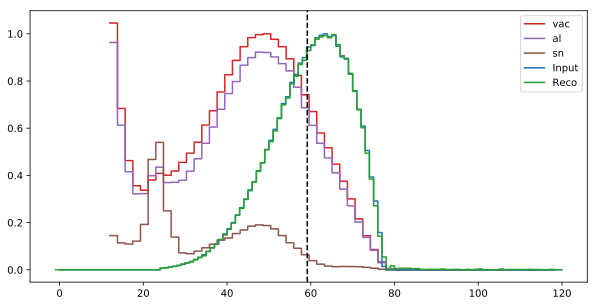

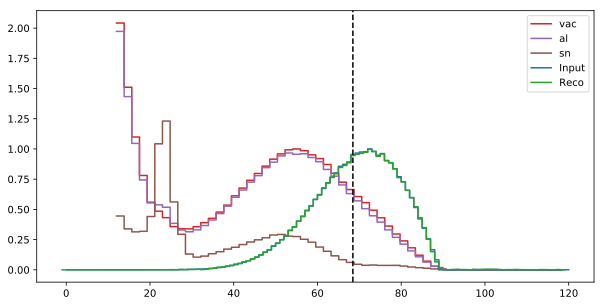

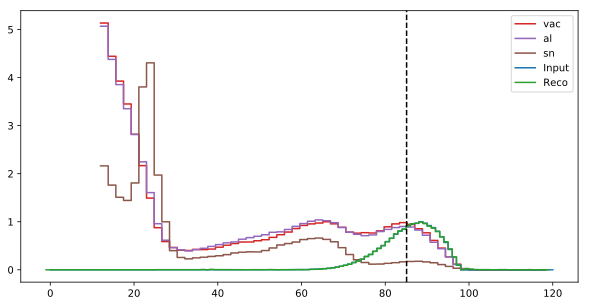

In [155]:
plotPrediction(res, deconv_data_test, deconv_data_true_test, bins=bins, N=3)

## Measurement Data (ToT)

In [163]:
import os
import cPickle
spectra_dir = 'NSpectraMeas/'

titles = ['vac', 'al', 'sn']
spectra_meas = {t: [] for t in titles}

dataEnergies = []
for fn in os.listdir(spectra_dir):
    if not fn.endswith('.p'):
        continue
    # print int(fn.split('Det1N')[-1].split('.p')[0])
    dataEnergies.append( int(fn.split('Det1N')[-1].split('.p')[0]) )

    data = cPickle.load(open(spectra_dir + fn, 'rb'))
    # hist_vac, _ = np.histogram(data['vac'], bins=bins)
    hist_vac = data['vac']
    spectra_meas['vac'].append( hist_vac / float(np.max(hist_vac[bins[:-1] >= 30])))
    for t in titles[1:]:
        # hist, _ = np.histogram(data[t], bins=bins)
        hist = data[t]
        spectra_meas[t].append( hist / float(np.max(hist_vac[bins[:-1] >= 30])) )

BINS_EVAL = len(spectra_meas['vac'])

In [164]:
data_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'x': np.dstack((np.asarray(spectra_meas['vac']), np.asarray(spectra_meas['al']), np.asarray(spectra_meas['sn']))).transpose((0, 2, 1))},
    y=np.asarray(spectra_meas['vac']),
    num_epochs=1,
    batch_size=BINS_EVAL,
    shuffle=False)

res = estimator.predict(input_fn=data_input_fn)

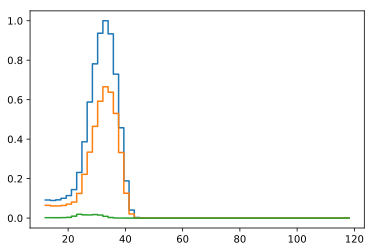

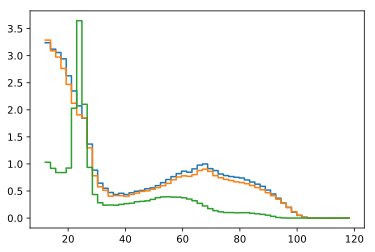

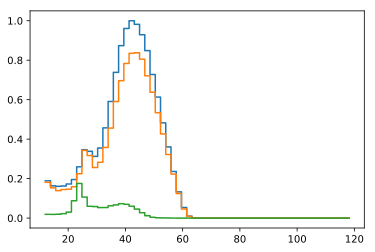

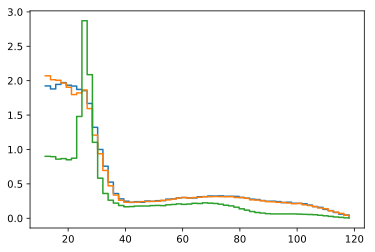

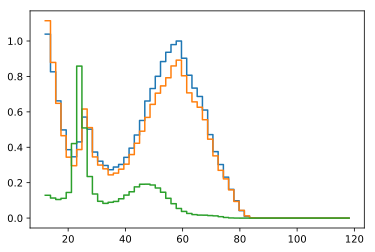

In [165]:
for idx in range(BINS_EVAL):
    for t in titles:
        plt.step(bins[:-1], spectra_meas[t][idx], where='post')
    plt.show()

Tensor("Cast:0", shape=(?, 3, 59), dtype=float32) 121
Batch: 5 177
Encoder Output: Tensor("encoder/output:0", shape=(?, 3, 59, 1), dtype=float32)
Hidden units: [1]
Decoder output: Tensor("decoder/Abs:0", shape=(?, 121), dtype=float32)
INFO:tensorflow:Restoring parameters from model_dir/model_NSpectra15/model.ckpt-600000
Mean: 36.344709216572966
Mean: 83.44580834575808
Mean: 48.63102303332924
Mean: 87.21139153158224
Mean: 65.02993789899537


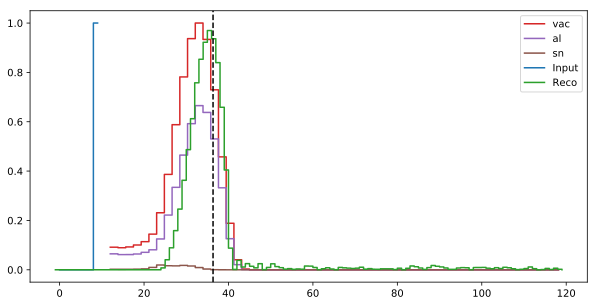

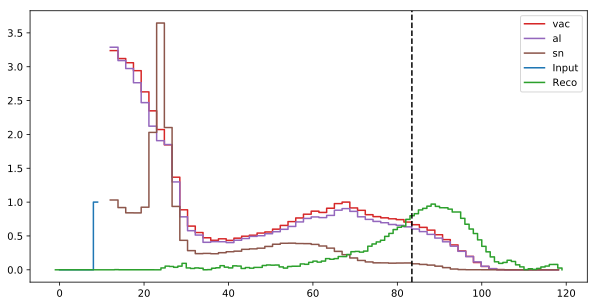

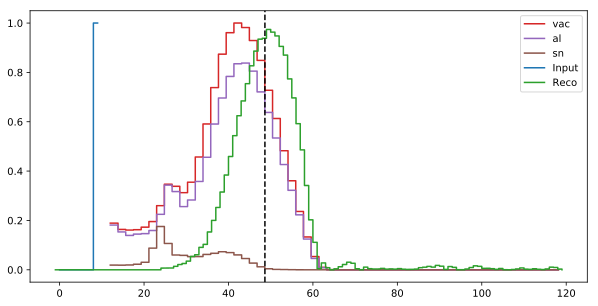

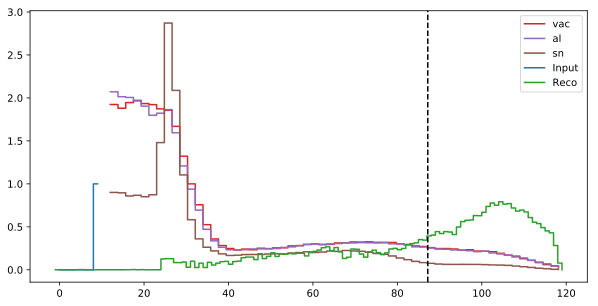

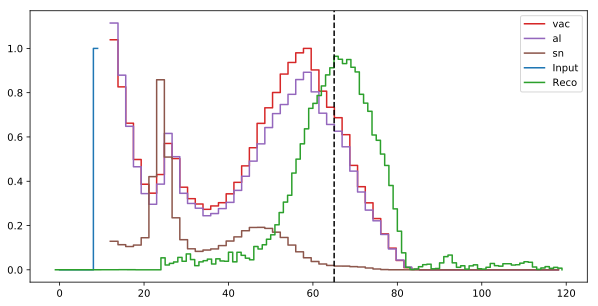

In [166]:
plotPrediction(res, spectra_meas, [range(10)]*len(spectra_meas['vac']), bins, N=BINS_EVAL)

## N-Series Measurements

In [ ]:
hist, hist_true = deconvDataChoice(data_dict, fluenceDict, dataEnergies, bins, minE=12, maxE=120, NSeries=True, true_binning=False)

In [ ]:
plt.step(bins[:-1], hist['vac'][0], where='post')
plt.step(bins[:-1], hist['al'][0], where='post')
plt.step(bins[:-1], hist['sn'][0], where='post')

In [ ]:
# Get correction function
hist_corr = {t: [] for t in titles}
deconv_data_corr = {t: [] for t in titles}
for t in titles:
    for h in deconv_data[t]:
        corr = np.nanmean([np.where(abs(spectra_meas[t][i] / deconv_data[t][i]) <= 2, spectra_meas[t][i] / deconv_data[t][i], np.nan) for i in range(len(spectra_meas[t]))], axis=0)
        plt.plot(corr)
        new_h = np.nan_to_num(h * corr) # spectra_meas[t][3] / hist[t][3]
        hist_corr[t].append( new_h )
        deconv_data_corr[t].append( new_h )
        
# plt.show()

for idx, energy in enumerate(dataEnergies):
    fig, ax = plt.subplots(2, 1, gridspec_kw = {'height_ratios': [6, 2]}, sharex=True)
    for t_idx, t in enumerate(titles):
        # ax[0].step(bins[:-1], hist[t][idx], where='post', color='C%d' % t_idx)
        ax[0].step(bins[:-1], spectra_meas[t][idx], where='post', color='C%d' % t_idx, alpha=.7)
        ax[0].step(bins[:-1], hist_corr[t][idx] / max(hist_corr['vac'][idx]), where='post', color='C%d' % t_idx, alpha=.3)
        ax[1].step(bins[:-1], 1 - spectra_meas[t][idx] / (hist_corr[t][idx] / max(hist_corr['vac'][idx])), where='post', color='C%d' % t_idx)
    ax[1].set_ylim(-1, 1)
    ax[0].plot(hist_true[idx])

    plt.show()